In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

%load_ext autoreload
%autoreload 2

In [2]:
with open("data/pkl_files/trimmed_inputs.pkl", "rb") as fp:
    old_inputs = pickle.load(fp)
with open("data/pkl_files/trimmed_outputs.pkl", "rb") as fp:
    old_outputs = pickle.load(fp)

In [3]:
# Sanity check
print(old_inputs.shape)
print(old_outputs.shape)

(25650, 4, 32, 32)
(25650, 1, 32, 32)


In [4]:
inputs = old_inputs
outputs = old_outputs

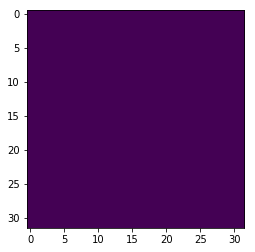

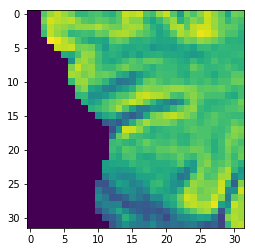

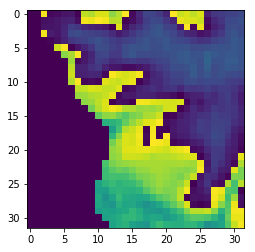

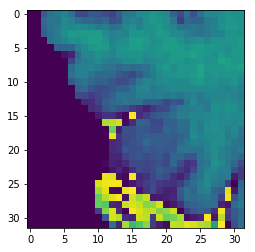

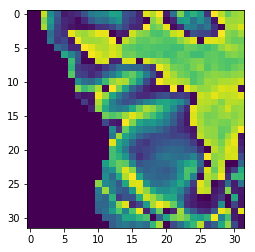

In [5]:
# Sanity Check
idx = np.random.randint(0, inputs.shape[0])
def plot_sampled_images(idx):    
    cropped_seg_img = outputs[idx,0,:,:]
    plt.imshow(cropped_seg_img)
    plt.show()
    cropped_flair_img = inputs[idx,0,:,:]
    plt.imshow(cropped_flair_img)
    plt.show()
    cropped_t1_img = inputs[idx,1,:,:]
    plt.imshow(cropped_t1_img)
    plt.show()
    cropped_t1ce_img = inputs[idx,2,:,:]
    plt.imshow(cropped_t1ce_img)
    plt.show()
    cropped_t2_img = inputs[idx,3,:,:]
    plt.imshow(cropped_t2_img)
    plt.show()
plot_sampled_images(idx)

In [6]:
np.random.seed(0)
shuffled_idxs = list(range(inputs.shape[0]))
np.random.shuffle(shuffled_idxs)
train_cutoff = int(inputs.shape[0]*75/100)
val_cutoff = int(inputs.shape[0]*95/100)

train_inputs = []
train_outputs = []
val_inputs = []
val_outputs = []
test_inputs = []
test_outputs = []

for iteration, idx in enumerate(shuffled_idxs):
    if iteration < train_cutoff:
        train_inputs.append(inputs[idx])
        train_outputs.append(outputs[idx])
    elif iteration < val_cutoff:
        val_inputs.append(inputs[idx])
        val_outputs.append(outputs[idx])
    else:
        test_inputs.append(inputs[idx])
        test_outputs.append(outputs[idx])

In [7]:
# sanity check
print(len(train_inputs))
print(len(train_outputs))
print(len(val_inputs))
print(len(val_outputs))
print(len(test_inputs))
print(len(test_outputs))

19237
19237
5130
5130
1283
1283


In [8]:
train_inputs = np.asarray(train_inputs)
val_inputs = np.asarray(val_inputs)
test_inputs = np.asarray(test_inputs)

train_inputs_mean = np.mean(train_inputs, axis=0)
train_inputs_std = np.std(train_inputs, axis=0)

train_inputs -= train_inputs_mean
train_inputs /= train_inputs_std
val_inputs -= train_inputs_mean
val_inputs /= train_inputs_std
test_inputs -= train_inputs_mean
test_inputs /= train_inputs_std

In [9]:
train_outputs = np.asarray(train_outputs)
n_tumor_pixels = np.count_nonzero(train_outputs)
n_tumor1 = np.count_nonzero(train_outputs==1)
n_tumor2 = np.count_nonzero(train_outputs==2)
n_tumor3 = np.count_nonzero(train_outputs==3)
n_tumor4 = np.count_nonzero(train_outputs==4)
total_pixels = train_outputs.shape[0]*train_outputs.shape[2]*train_outputs.shape[3]
print(total_pixels)
n_blank_pixels = total_pixels - n_tumor_pixels
frac_tumor = n_tumor_pixels/total_pixels
print(frac_tumor)

19698688
0.06718163158886521


In [10]:
train_data = []
val_data = []
test_data = []

for idx in range(train_inputs.shape[0]):
    train_data.append([train_inputs[idx], train_outputs[idx]])
for idx in range(val_inputs.shape[0]):
    val_data.append([val_inputs[idx], val_outputs[idx]])
for idx in range(test_inputs.shape[0]):
    test_data.append([test_inputs[idx], test_outputs[idx]])

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=64)

print(len(train_loader))
print(len(train_data))

301
19237


In [12]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [13]:
from models.unet import *

In [14]:
def test_UNet():
    channels_in = 4
    n_classes = 5
    x = torch.zeros((64, 4, 32, 32), dtype=dtype)
    model = UNet(channels_in, n_classes)
    scores = model(x)
    print(scores.size())
test_UNet()

torch.Size([64, 5, 32, 32])


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [21]:
# Defining all parameters 
print_every = 25
learning_rate = 1e-1
input_channels = 4
n_classes = 5
model = UNet(channel_in=input_channels, classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99), eps=1e-08, weight_decay=learning_rate/float(250), amsgrad=False)
# criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([1.0, n_blank_pixel/float(n_tumor_pixels)]).cuda()) 
class_weights = [1.0, n_blank_pixels/float(n_tumor1), n_blank_pixels/float(n_tumor2), 1.0, n_blank_pixels/float(n_tumor4)]
print(class_weights)
criterion = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).cuda()) 

if USE_GPU and torch.cuda.is_available():
    model.cuda()
    print("did this")

[1.0, 55.02574714020483, 24.78145204141908, 1.0, 74.10709158076433]
did this


In [22]:
def create_masks(x):
    mask = np.zeros((n_classes, x.shape[0], x.shape[1]))
    for c in range(n_classes):
        mask[c] = x == c
    return mask

In [23]:
def compute_iou(scores, output):  
    scores = scores.astype(np.bool)
    output = output.astype(np.bool)
    overlap = scores*output
    union = scores+output # Logical OR
    IOU = (overlap.sum())/(float(union.sum())+1e-10) 
    return IOU

In [24]:
def iou_metric(preds, labels):
    # preds and labels are of size (64, 32, 32)
    # return average iou value for each class
    numpy_preds = preds.cpu().numpy()  
    numpy_labels = labels.cpu().numpy()
    
    iou_tracker = np.zeros((numpy_preds.shape[0], n_classes))
    # get the masks
    for idx in range(numpy_preds.shape[0]):
        """plt.title('Segmented Output')
        plt.imshow(numpy_preds[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_labels[idx,:,:])
        plt.show()"""
        pred_mask = create_masks(numpy_preds[idx])
        label_mask = create_masks(numpy_labels[idx])
        for c in range(n_classes):
            iou_tracker[idx, c] = compute_iou(pred_mask[c], label_mask[c])
        # print(iou_tracker[idx])
    # print(np.mean(iou_tracker, axis=0))
    return np.mean(iou_tracker, axis=0)  

In [25]:
def check_iou(loader, model):
    all_iou = np.zeros((len(loader),n_classes))

    with torch.no_grad():
        for t, (x,y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float).view(y.shape[0], 32, 32)
            scores = model(x)
            _, preds = scores.max(1)
            
            all_iou[t] = iou_metric(preds, y)
    # print(np.mean(all_iou, axis=0))
    return np.mean(all_iou, axis=0)

In [26]:
check_iou(val_loader, model)

array([9.34187765e-01, 8.71917916e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [27]:
def plot_output(scores, y):
    with torch.no_grad():
        _, preds = scores.max(1)
        numpy_scores = preds.cpu().numpy().astype(np.uint8)
        numpy_truth = y.cpu().numpy().astype(np.uint8)
        idx = np.random.randint(1, y.shape[0])
        while(np.count_nonzero(numpy_truth[idx]) < int(0.10*32*32)):
            idx = np.random.randint(1, y.shape[0])
        plt.title('Segmented Output')
        plt.imshow(numpy_scores[idx,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_truth[idx,:,:])
        plt.show()

In [28]:
import torch.nn.functional as F
train_loss_history = []
val_loss_history = []
cur_epoch_train_loss = []
cur_epoch_val_loss = []
averaged_train_loss_hist = []
averaged_val_loss_history = []
val_iou_history = []
train_iou_history = []

plot_every = 100
def train(model, optimizer, epochs=1):
    
    model = model.to(device=device)
    train_loss_history.clear()
    val_loss_history.clear()
    cur_epoch_train_loss.clear()
    cur_epoch_val_loss.clear()
    averaged_train_loss_hist.clear()
    averaged_val_loss_history.clear()
    val_iou_history.clear()
    train_iou_history.clear()
    
    for e in range(epochs):
        cur_epoch_train_loss.clear()
        cur_epoch_val_loss.clear()
        for t, (x,y) in enumerate(train_loader):
            model.train()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            # print(labels.shape)

            train_scores = model(x)
            train_loss = criterion(train_scores, labels)
            train_loss_history.append(train_loss.item())
            cur_epoch_train_loss.append(train_loss.item())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            # print(t)
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, train_loss.item()))
                val_iou = check_iou(val_loader, model)
                val_iou_history.append(val_iou)
                train_iou = check_iou(train_loader, model)
                train_iou_history.append(train_iou)
                print('Validation IOU: ', val_iou)
                print('Training IOU: ', train_iou)
            # if t % plot_every == 0:
                # plot_output(scores, labels)
        for t, (x,y) in enumerate(val_loader):
            model.eval()
            x = x.to(device=device, dtype=dtype)
            labels = y.to(device=device, dtype=torch.long).view(y.shape[0], 32, 32)
            
            val_scores = model(x)
            val_loss = criterion(val_scores, labels)
            val_loss_history.append(val_loss.item())
            cur_epoch_val_loss.append(val_loss.item())
        averaged_train_loss_hist.append(np.mean(np.asarray(cur_epoch_train_loss)))
        averaged_val_loss_history.append(np.mean(np.asarray(cur_epoch_val_loss)))
        print('Epoch %d, Average Training Loss = %.4f, Average Validation Loss = %.4f' % \
              (e, np.mean(np.asarray(cur_epoch_train_loss)), np.mean(np.asarray(cur_epoch_val_loss))))

In [29]:
train(model, optimizer, epochs=250)

Epoch 0, Iteration 0, loss = 1.5964
Validation IOU:  [9.34113289e-01 9.42477545e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Training IOU:  [9.32174344e-01 9.04095048e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Epoch 0, Iteration 25, loss = 1.6013
Validation IOU:  [0.93466722 0.         0.         0.         0.        ]
Training IOU:  [0.93279297 0.         0.         0.         0.        ]
Epoch 0, Iteration 50, loss = 1.4666
Validation IOU:  [0.93456346 0.         0.         0.         0.        ]
Training IOU:  [0.93284886 0.         0.         0.         0.        ]
Epoch 0, Iteration 75, loss = 1.5414
Validation IOU:  [0.93438544 0.         0.         0.         0.        ]
Training IOU:  [0.9328415 0.        0.        0.        0.       ]
Epoch 0, Iteration 100, loss = 1.5415
Validation IOU:  [0.93372829 0.         0.         0.         0.        ]
Training IOU:  [0.93280472 0.         0.         0.         0.        ]
Epoch 0, Iteration 125, loss = 1.5090
Validation

Epoch 3, Iteration 75, loss = 1.4502
Validation IOU:  [0.56442345 0.0057059  0.03888954 0.         0.01938175]
Training IOU:  [0.56461838 0.0057124  0.03979894 0.         0.01817516]
Epoch 3, Iteration 100, loss = 1.4903
Validation IOU:  [0.61453035 0.0061421  0.0379795  0.         0.01750693]
Training IOU:  [0.61793387 0.00589546 0.03886839 0.         0.01709829]
Epoch 3, Iteration 125, loss = 1.4991
Validation IOU:  [0.60007883 0.00413494 0.03511992 0.         0.01707698]
Training IOU:  [0.60224356 0.00426165 0.03532996 0.         0.01725864]
Epoch 3, Iteration 150, loss = 1.3582
Validation IOU:  [0.56749672 0.0125299  0.03682578 0.         0.01337712]
Training IOU:  [0.56856172 0.01299568 0.03686618 0.         0.01312608]
Epoch 3, Iteration 175, loss = 1.3255
Validation IOU:  [0.54727202 0.01125918 0.03696987 0.         0.01822226]
Training IOU:  [0.54672047 0.01106566 0.03741535 0.         0.01707166]
Epoch 3, Iteration 200, loss = 1.4972
Validation IOU:  [0.5694882  0.00509118 0.0

Epoch 6, Iteration 200, loss = 1.3574
Validation IOU:  [0.60086718 0.01278154 0.03726739 0.         0.01705862]
Training IOU:  [0.60003759 0.01370859 0.03856317 0.         0.01634809]
Epoch 6, Iteration 225, loss = 1.2937
Validation IOU:  [0.67197801 0.00986335 0.03889854 0.         0.01841396]
Training IOU:  [0.67599448 0.01038877 0.04082562 0.         0.01772927]
Epoch 6, Iteration 250, loss = 1.3407
Validation IOU:  [0.64113748 0.01023936 0.03956965 0.         0.02003826]
Training IOU:  [0.64597501 0.01085519 0.04170051 0.         0.0194868 ]
Epoch 6, Iteration 275, loss = 1.3967
Validation IOU:  [0.66461118 0.00883044 0.03905642 0.         0.01985284]
Training IOU:  [0.66638228 0.01022098 0.04161383 0.         0.01939459]
Epoch 6, Iteration 300, loss = 1.2947
Validation IOU:  [0.60979424 0.01226731 0.03914524 0.         0.01497545]
Training IOU:  [0.61122476 0.01393877 0.04214187 0.         0.01456291]
Epoch 6, Average Training Loss = 1.3727, Average Validation Loss = 1.3959
Epoch 

Epoch 9, Average Training Loss = 1.3529, Average Validation Loss = 1.3705
Epoch 10, Iteration 0, loss = 1.4631
Validation IOU:  [0.57106821 0.0077082  0.03773393 0.         0.02109795]
Training IOU:  [0.57303735 0.00874768 0.03918545 0.         0.02016237]
Epoch 10, Iteration 25, loss = 1.4458
Validation IOU:  [0.61493294 0.01126394 0.03667086 0.         0.01835695]
Training IOU:  [0.61696155 0.01253556 0.03880551 0.         0.01798341]
Epoch 10, Iteration 50, loss = 1.3698
Validation IOU:  [0.5899637  0.00939978 0.03693602 0.         0.02155183]
Training IOU:  [0.59268995 0.01149605 0.03987064 0.         0.02087219]
Epoch 10, Iteration 75, loss = 1.4577
Validation IOU:  [0.60612015 0.01198149 0.03277533 0.         0.018067  ]
Training IOU:  [0.60837644 0.01346224 0.03533243 0.         0.01743398]
Epoch 10, Iteration 100, loss = 1.3463
Validation IOU:  [0.60072765 0.00749674 0.03726673 0.         0.02175158]
Training IOU:  [0.60243502 0.00877652 0.04000998 0.         0.02124115]
Epoch 

Epoch 13, Iteration 100, loss = 1.2391
Validation IOU:  [0.62740674 0.00894814 0.0371368  0.         0.02239702]
Training IOU:  [0.63209925 0.01170723 0.03935784 0.         0.02296317]
Epoch 13, Iteration 125, loss = 1.4495
Validation IOU:  [0.61362007 0.01086909 0.0394537  0.         0.02400169]
Training IOU:  [0.61826844 0.01325745 0.04166425 0.         0.02271089]
Epoch 13, Iteration 150, loss = 1.2518
Validation IOU:  [0.621984   0.01065459 0.0383571  0.         0.02323549]
Training IOU:  [0.62507976 0.01328265 0.04119579 0.         0.0228263 ]
Epoch 13, Iteration 175, loss = 1.4009
Validation IOU:  [0.63225291 0.0078454  0.04019525 0.         0.02313791]
Training IOU:  [0.63598691 0.01057203 0.04447805 0.         0.02255174]
Epoch 13, Iteration 200, loss = 1.3759
Validation IOU:  [0.61422559 0.01262817 0.03592131 0.         0.02200585]
Training IOU:  [0.61952237 0.01445078 0.04047605 0.         0.0218539 ]
Epoch 13, Iteration 225, loss = 1.2282
Validation IOU:  [0.63328203 0.00978

Validation IOU:  [0.66603027 0.01271303 0.04075411 0.         0.02161426]
Training IOU:  [0.66772624 0.01481978 0.04483128 0.         0.02194041]
Epoch 16, Iteration 225, loss = 1.3050
Validation IOU:  [0.65846473 0.01029474 0.04005969 0.         0.02292094]
Training IOU:  [0.66310396 0.01380507 0.04416592 0.         0.02371316]
Epoch 16, Iteration 250, loss = 1.2612
Validation IOU:  [0.64962249 0.00719593 0.03924353 0.         0.02425225]
Training IOU:  [0.65479053 0.00984016 0.04323079 0.         0.02427764]
Epoch 16, Iteration 275, loss = 1.4338
Validation IOU:  [0.64945571 0.0086115  0.04187067 0.         0.02469127]
Training IOU:  [0.65258608 0.01142493 0.04490037 0.         0.02438687]
Epoch 16, Iteration 300, loss = 1.5265
Validation IOU:  [0.60672665 0.01118861 0.03714875 0.         0.02445905]
Training IOU:  [0.61278763 0.01368987 0.0396111  0.         0.02404406]
Epoch 16, Average Training Loss = 1.3055, Average Validation Loss = 1.3269
Epoch 17, Iteration 0, loss = 1.1695
Va

Epoch 19, Average Training Loss = 1.2894, Average Validation Loss = 1.3183
Epoch 20, Iteration 0, loss = 1.2106
Validation IOU:  [0.68723297 0.0110423  0.0416305  0.         0.02470589]
Training IOU:  [0.69387532 0.01515894 0.04646107 0.         0.02550405]
Epoch 20, Iteration 25, loss = 1.2411
Validation IOU:  [0.67708892 0.0114765  0.04548196 0.         0.02438307]
Training IOU:  [0.68044744 0.01549471 0.04951005 0.         0.02426458]
Epoch 20, Iteration 50, loss = 1.3169
Validation IOU:  [0.67351641 0.01287071 0.03914632 0.         0.022807  ]
Training IOU:  [0.67748142 0.01670536 0.04331315 0.         0.02388222]
Epoch 20, Iteration 75, loss = 1.2453
Validation IOU:  [0.69910024 0.00932755 0.04156635 0.         0.02470825]
Training IOU:  [0.70546057 0.01300333 0.0472212  0.         0.02437829]
Epoch 20, Iteration 100, loss = 1.4021
Validation IOU:  [0.67328912 0.01125016 0.03858661 0.         0.02411235]
Training IOU:  [0.6778845  0.01474121 0.04377722 0.         0.02491258]
Epoch

Epoch 23, Iteration 100, loss = 1.3017
Validation IOU:  [0.71142599 0.01052308 0.04201549 0.         0.02334314]
Training IOU:  [0.71683042 0.01544288 0.04817502 0.         0.02480406]
Epoch 23, Iteration 125, loss = 1.3621
Validation IOU:  [0.69649851 0.01100923 0.04302599 0.         0.0240622 ]
Training IOU:  [0.70399339 0.0158722  0.04700893 0.         0.02527246]
Epoch 23, Iteration 150, loss = 1.2311
Validation IOU:  [0.68814521 0.01283569 0.0369728  0.         0.02126912]
Training IOU:  [0.69432495 0.01638261 0.04156261 0.         0.02340634]
Epoch 23, Iteration 175, loss = 1.3654
Validation IOU:  [0.70192389 0.0100426  0.04175178 0.         0.02336952]
Training IOU:  [0.7086367  0.01460109 0.04660333 0.         0.02497982]
Epoch 23, Iteration 200, loss = 1.1785
Validation IOU:  [0.65553709 0.01231616 0.04382395 0.         0.0236279 ]
Training IOU:  [0.6597657  0.01705713 0.0478983  0.         0.02514604]
Epoch 23, Iteration 225, loss = 1.2804
Validation IOU:  [0.65928344 0.01071

Validation IOU:  [0.65597496 0.01158638 0.04035189 0.         0.02378645]
Training IOU:  [0.66383238 0.0166889  0.04641819 0.         0.02566584]
Epoch 26, Iteration 225, loss = 1.2195
Validation IOU:  [0.66808445 0.01209855 0.04216227 0.         0.02525001]
Training IOU:  [0.67295794 0.01683432 0.0482158  0.         0.02519906]
Epoch 26, Iteration 250, loss = 1.2375
Validation IOU:  [0.67447025 0.01032109 0.03878046 0.         0.02543602]
Training IOU:  [0.68266938 0.01535344 0.04444598 0.         0.0264693 ]
Epoch 26, Iteration 275, loss = 1.2898
Validation IOU:  [0.70766745 0.01050096 0.04134243 0.         0.02423613]
Training IOU:  [0.71464718 0.01515924 0.0476429  0.         0.0257739 ]
Epoch 26, Iteration 300, loss = 1.2201
Validation IOU:  [0.66975949 0.01253924 0.04314099 0.         0.02543267]
Training IOU:  [0.67798287 0.01839368 0.04745589 0.         0.02591863]
Epoch 26, Average Training Loss = 1.2550, Average Validation Loss = 1.3227
Epoch 27, Iteration 0, loss = 1.1897
Va

Epoch 29, Average Training Loss = 1.2437, Average Validation Loss = 1.3027
Epoch 30, Iteration 0, loss = 1.3836
Validation IOU:  [0.69457393 0.01193155 0.04544565 0.         0.02442306]
Training IOU:  [0.70329228 0.01834964 0.05219052 0.         0.02724992]
Epoch 30, Iteration 25, loss = 1.1416
Validation IOU:  [0.70657668 0.01245298 0.04181412 0.         0.02332038]
Training IOU:  [0.714566   0.01821038 0.04888304 0.         0.02704213]
Epoch 30, Iteration 50, loss = 1.2543
Validation IOU:  [0.71887886 0.01020512 0.0415882  0.         0.0235526 ]
Training IOU:  [0.72767974 0.01628495 0.04921206 0.         0.02669296]
Epoch 30, Iteration 75, loss = 1.1648
Validation IOU:  [0.70751288 0.00989165 0.04518696 0.         0.02364577]
Training IOU:  [0.71221241 0.01572717 0.05204704 0.         0.02642937]
Epoch 30, Iteration 100, loss = 1.1997
Validation IOU:  [0.69756299 0.01349052 0.04316159 0.         0.02388059]
Training IOU:  [0.70227403 0.01947474 0.04918476 0.         0.02651748]
Epoch

Epoch 33, Iteration 100, loss = 1.1744
Validation IOU:  [0.72668394 0.01072709 0.04420599 0.         0.02345969]
Training IOU:  [0.73607329 0.01883127 0.05141367 0.         0.02671304]
Epoch 33, Iteration 125, loss = 1.3354
Validation IOU:  [0.73565281 0.01167196 0.0405639  0.         0.02485628]
Training IOU:  [0.74320866 0.01862922 0.04810077 0.         0.02744766]
Epoch 33, Iteration 150, loss = 1.1760
Validation IOU:  [0.71727921 0.01278734 0.04154347 0.         0.02335235]
Training IOU:  [0.72765457 0.01971347 0.0491841  0.         0.02748536]
Epoch 33, Iteration 175, loss = 1.1968
Validation IOU:  [0.72160977 0.01340594 0.04167631 0.         0.02444316]
Training IOU:  [0.72941127 0.0199469  0.04975757 0.         0.02795314]
Epoch 33, Iteration 200, loss = 1.1658
Validation IOU:  [0.70292357 0.01214165 0.04242996 0.         0.02489974]
Training IOU:  [0.70933443 0.01891124 0.05131401 0.         0.02779794]
Epoch 33, Iteration 225, loss = 1.1738
Validation IOU:  [0.70224538 0.01158

Validation IOU:  [0.71717727 0.01235714 0.04414725 0.         0.02463325]
Training IOU:  [0.72366779 0.01945316 0.05379404 0.         0.02828727]
Epoch 36, Iteration 225, loss = 1.1948
Validation IOU:  [0.74758955 0.0116279  0.04421514 0.         0.02330333]
Training IOU:  [0.75421926 0.01985968 0.05224901 0.         0.02665909]
Epoch 36, Iteration 250, loss = 1.1622
Validation IOU:  [0.72080752 0.01115027 0.04628524 0.         0.02386453]
Training IOU:  [0.72851956 0.01986741 0.05373269 0.         0.02808832]
Epoch 36, Iteration 275, loss = 1.1607
Validation IOU:  [0.73018145 0.01233229 0.04418618 0.         0.02384612]
Training IOU:  [0.73935546 0.02051624 0.05304266 0.         0.02841057]
Epoch 36, Iteration 300, loss = 1.3121
Validation IOU:  [0.69775933 0.01192979 0.04191523 0.         0.02353784]
Training IOU:  [0.7066075  0.02027781 0.05049846 0.         0.02815436]
Epoch 36, Average Training Loss = 1.2032, Average Validation Loss = 1.3056
Epoch 37, Iteration 0, loss = 1.2170
Va

Epoch 39, Average Training Loss = 1.1937, Average Validation Loss = 1.3097
Epoch 40, Iteration 0, loss = 1.2197
Validation IOU:  [0.7288802  0.01031769 0.04536699 0.         0.02362227]
Training IOU:  [0.7365007  0.01937757 0.05526165 0.         0.02905278]
Epoch 40, Iteration 25, loss = 1.1642
Validation IOU:  [0.74471439 0.01188067 0.04355241 0.         0.02335347]
Training IOU:  [0.75460772 0.02058968 0.05338572 0.         0.02827995]
Epoch 40, Iteration 50, loss = 1.3062
Validation IOU:  [0.73755066 0.01143346 0.04467074 0.         0.02226891]
Training IOU:  [0.74683647 0.02009885 0.05429384 0.         0.02867075]
Epoch 40, Iteration 75, loss = 1.2517
Validation IOU:  [0.71256037 0.0106645  0.04436721 0.         0.02483518]
Training IOU:  [0.71885283 0.01941684 0.05443869 0.         0.02845822]
Epoch 40, Iteration 100, loss = 1.3205
Validation IOU:  [0.63458493 0.01077104 0.0388459  0.         0.02231277]
Training IOU:  [0.64142349 0.01800395 0.04714021 0.         0.02623244]
Epoch

Epoch 43, Iteration 100, loss = 1.1504
Validation IOU:  [0.71202704 0.01128828 0.04437151 0.         0.022944  ]
Training IOU:  [0.72138241 0.02086481 0.05374692 0.         0.02860419]
Epoch 43, Iteration 125, loss = 1.1320
Validation IOU:  [0.72562971 0.01158474 0.04486835 0.         0.02285737]
Training IOU:  [0.73495173 0.02092558 0.05375856 0.         0.02870995]
Epoch 43, Iteration 150, loss = 1.1850
Validation IOU:  [0.72699006 0.00986785 0.0455798  0.         0.02244359]
Training IOU:  [0.73677582 0.01952331 0.05380879 0.         0.0273137 ]
Epoch 43, Iteration 175, loss = 1.2194
Validation IOU:  [0.72646603 0.00952079 0.04622418 0.         0.02298826]
Training IOU:  [0.73420748 0.01924341 0.05673488 0.         0.02855918]
Epoch 43, Iteration 200, loss = 1.1531
Validation IOU:  [0.72387158 0.01187621 0.04389781 0.         0.02200544]
Training IOU:  [0.73293088 0.02141613 0.0537974  0.         0.02843751]
Epoch 43, Iteration 225, loss = 1.1737
Validation IOU:  [0.71126899 0.00955

Validation IOU:  [0.74301459 0.01074519 0.04740817 0.         0.02321656]
Training IOU:  [0.7516614  0.02028837 0.05768591 0.         0.02986811]
Epoch 46, Iteration 225, loss = 1.1864
Validation IOU:  [0.72807839 0.01290058 0.04507365 0.         0.02337636]
Training IOU:  [0.7389526  0.02261314 0.05652635 0.         0.02936266]
Epoch 46, Iteration 250, loss = 1.1984
Validation IOU:  [0.71365476 0.01156837 0.04564314 0.         0.02404892]
Training IOU:  [0.72395907 0.02159026 0.0558183  0.         0.02966802]
Epoch 46, Iteration 275, loss = 1.1440
Validation IOU:  [0.72700515 0.01177921 0.04726914 0.         0.02354652]
Training IOU:  [0.73638875 0.02144089 0.05760376 0.         0.02954607]
Epoch 46, Iteration 300, loss = 1.0846
Validation IOU:  [0.74173892 0.01074575 0.04530386 0.         0.02434235]
Training IOU:  [0.75392385 0.02014224 0.05600263 0.         0.02938419]
Epoch 46, Average Training Loss = 1.1701, Average Validation Loss = 1.3048
Epoch 47, Iteration 0, loss = 1.1449
Va

Epoch 49, Average Training Loss = 1.1667, Average Validation Loss = 1.3048
Epoch 50, Iteration 0, loss = 1.3399
Validation IOU:  [0.73014023 0.01157802 0.04456543 0.         0.02415671]
Training IOU:  [0.73987401 0.02248004 0.05595093 0.         0.02975701]
Epoch 50, Iteration 25, loss = 1.1512
Validation IOU:  [0.74715696 0.01038989 0.04445741 0.         0.02362518]
Training IOU:  [0.7577358  0.02240252 0.05543598 0.         0.03031817]
Epoch 50, Iteration 50, loss = 1.1420
Validation IOU:  [0.72952888 0.01221143 0.04589707 0.         0.023138  ]
Training IOU:  [0.74003861 0.02341108 0.05760904 0.         0.03007161]
Epoch 50, Iteration 75, loss = 1.1294
Validation IOU:  [0.74831176 0.00990309 0.04564545 0.         0.02302758]
Training IOU:  [0.76039447 0.02139646 0.05622748 0.         0.03011318]
Epoch 50, Iteration 100, loss = 1.2256
Validation IOU:  [0.71918646 0.01146744 0.04673062 0.         0.0226622 ]
Training IOU:  [0.72988371 0.02313988 0.05736774 0.         0.02960536]
Epoch

Epoch 53, Iteration 100, loss = 1.1809
Validation IOU:  [0.74508339 0.0106799  0.04607828 0.         0.02287271]
Training IOU:  [0.75608114 0.02292177 0.05856841 0.         0.03052513]
Epoch 53, Iteration 125, loss = 1.1198
Validation IOU:  [0.73074558 0.01101215 0.0463822  0.         0.02306438]
Training IOU:  [0.7402745  0.02317818 0.05806984 0.         0.03009085]
Epoch 53, Iteration 150, loss = 1.1913
Validation IOU:  [0.72048394 0.01093097 0.04770977 0.         0.02296711]
Training IOU:  [0.7294365  0.02255548 0.05832239 0.         0.02987733]
Epoch 53, Iteration 175, loss = 1.1332
Validation IOU:  [0.74471    0.01053567 0.04751318 0.         0.02286065]
Training IOU:  [0.75552921 0.02293778 0.0596215  0.         0.03050503]
Epoch 53, Iteration 200, loss = 1.0637
Validation IOU:  [0.72549199 0.00964129 0.04496029 0.         0.0233129 ]
Training IOU:  [0.73663721 0.0213227  0.05694052 0.         0.02925276]
Epoch 53, Iteration 225, loss = 1.1286
Validation IOU:  [0.74318241 0.01212

Validation IOU:  [0.76213385 0.01131756 0.04561346 0.         0.02164276]
Training IOU:  [0.77505231 0.02423485 0.05798368 0.         0.03091651]
Epoch 56, Iteration 225, loss = 1.1685
Validation IOU:  [0.74941595 0.00989323 0.04592547 0.         0.02364419]
Training IOU:  [0.76071758 0.02219828 0.05764874 0.         0.03007938]
Epoch 56, Iteration 250, loss = 1.1897
Validation IOU:  [0.75507261 0.01030595 0.0454949  0.         0.02424679]
Training IOU:  [0.76559843 0.02318474 0.05619651 0.         0.03060716]
Epoch 56, Iteration 275, loss = 1.1786
Validation IOU:  [0.71943015 0.01088675 0.04577775 0.         0.02280381]
Training IOU:  [0.72872268 0.02334942 0.05785245 0.         0.03015807]
Epoch 56, Iteration 300, loss = 1.0121
Validation IOU:  [0.72398165 0.01314119 0.0458462  0.         0.02253322]
Training IOU:  [0.73752527 0.02385716 0.05870726 0.         0.03081821]
Epoch 56, Average Training Loss = 1.1426, Average Validation Loss = 1.3114
Epoch 57, Iteration 0, loss = 1.1819
Va

Epoch 59, Average Training Loss = 1.1401, Average Validation Loss = 1.3226
Epoch 60, Iteration 0, loss = 1.1141
Validation IOU:  [0.74689578 0.01120782 0.04482451 0.         0.02237006]
Training IOU:  [0.7588354  0.02401883 0.058996   0.         0.03076952]
Epoch 60, Iteration 25, loss = 1.1156
Validation IOU:  [0.75557189 0.01134757 0.04739536 0.         0.02253367]
Training IOU:  [0.76512763 0.02418042 0.05977367 0.         0.03009432]
Epoch 60, Iteration 50, loss = 1.0539
Validation IOU:  [0.76300634 0.01061244 0.04729424 0.         0.02278784]
Training IOU:  [0.77273992 0.02340462 0.06002805 0.         0.03099716]
Epoch 60, Iteration 75, loss = 1.1647
Validation IOU:  [0.73856267 0.01200657 0.04481897 0.         0.02340009]
Training IOU:  [0.74842484 0.02367503 0.05839962 0.         0.03010903]
Epoch 60, Iteration 100, loss = 1.1940
Validation IOU:  [0.74864776 0.0099463  0.04730841 0.         0.02277312]
Training IOU:  [0.76016861 0.02320325 0.05940347 0.         0.0314542 ]
Epoch

Epoch 63, Iteration 100, loss = 1.2160
Validation IOU:  [0.76973203 0.01030699 0.04537656 0.         0.02251283]
Training IOU:  [0.78256854 0.0247349  0.05979321 0.         0.03106898]
Epoch 63, Iteration 125, loss = 1.1004
Validation IOU:  [0.76744469 0.01060719 0.04699444 0.         0.02149279]
Training IOU:  [0.77940884 0.02504786 0.06010415 0.         0.03167263]
Epoch 63, Iteration 150, loss = 1.0827
Validation IOU:  [0.77638642 0.01018153 0.04881085 0.         0.02220962]
Training IOU:  [0.79076341 0.02390002 0.06187378 0.         0.03174221]
Epoch 63, Iteration 175, loss = 1.0434
Validation IOU:  [0.772731   0.01237315 0.04533159 0.         0.02204349]
Training IOU:  [0.78557892 0.02524059 0.05896598 0.         0.03148548]
Epoch 63, Iteration 200, loss = 1.1755
Validation IOU:  [0.74507489 0.01138432 0.04679728 0.         0.02201668]
Training IOU:  [0.75783313 0.02398063 0.06024989 0.         0.03168254]
Epoch 63, Iteration 225, loss = 1.1313
Validation IOU:  [0.73999446 0.01326

Validation IOU:  [0.75331188 0.00919643 0.04784316 0.         0.02274209]
Training IOU:  [0.76735818 0.02425636 0.06165191 0.         0.03096846]
Epoch 66, Iteration 225, loss = 1.2512
Validation IOU:  [0.73064647 0.0098062  0.04612522 0.         0.0228303 ]
Training IOU:  [0.74526155 0.02435296 0.06011648 0.         0.03101693]
Epoch 66, Iteration 250, loss = 1.1588
Validation IOU:  [0.77741905 0.01023725 0.04594224 0.         0.01935447]
Training IOU:  [0.79095224 0.02540553 0.06175203 0.         0.03069155]
Epoch 66, Iteration 275, loss = 1.2039
Validation IOU:  [0.74007679 0.01130729 0.04583719 0.         0.02130093]
Training IOU:  [0.75288348 0.0250091  0.06010458 0.         0.03048215]
Epoch 66, Iteration 300, loss = 1.1408
Validation IOU:  [0.75207152 0.00989319 0.04503163 0.         0.02153161]
Training IOU:  [0.76610837 0.02485489 0.06072056 0.         0.03138855]
Epoch 66, Average Training Loss = 1.1263, Average Validation Loss = 1.3335
Epoch 67, Iteration 0, loss = 1.1357
Va

Epoch 69, Average Training Loss = 1.1178, Average Validation Loss = 1.3184
Epoch 70, Iteration 0, loss = 1.0902
Validation IOU:  [0.74839918 0.01006207 0.04605039 0.         0.02166661]
Training IOU:  [0.75973047 0.02424158 0.06151972 0.         0.03102521]
Epoch 70, Iteration 25, loss = 1.0883
Validation IOU:  [0.77902821 0.01092484 0.0452376  0.         0.02139833]
Training IOU:  [0.79375993 0.02595205 0.06151037 0.         0.03248119]
Epoch 70, Iteration 50, loss = 1.0870
Validation IOU:  [0.7894358  0.01041868 0.04394699 0.         0.02246625]
Training IOU:  [0.80149861 0.02566887 0.06097906 0.         0.03163318]
Epoch 70, Iteration 75, loss = 1.0763
Validation IOU:  [0.77405119 0.01055586 0.04749028 0.         0.02086347]
Training IOU:  [0.78690095 0.02525764 0.06307536 0.         0.03236439]
Epoch 70, Iteration 100, loss = 1.0983
Validation IOU:  [0.75680742 0.01018963 0.04638823 0.         0.02176525]
Training IOU:  [0.76969876 0.02481841 0.06148131 0.         0.03184057]
Epoch

Epoch 73, Iteration 100, loss = 1.0559
Validation IOU:  [0.7681083  0.00970861 0.0482146  0.         0.02243415]
Training IOU:  [0.78044105 0.02556066 0.06241049 0.         0.03264979]
Epoch 73, Iteration 125, loss = 1.1412
Validation IOU:  [0.75950307 0.01199412 0.04537493 0.         0.02145701]
Training IOU:  [0.77324413 0.02627271 0.06065836 0.         0.03196096]
Epoch 73, Iteration 150, loss = 1.0917
Validation IOU:  [0.77833963 0.00989733 0.04676256 0.         0.02204335]
Training IOU:  [0.79299687 0.02596834 0.06339668 0.         0.03309834]
Epoch 73, Iteration 175, loss = 1.0865
Validation IOU:  [0.76531394 0.00991274 0.04761852 0.         0.02198219]
Training IOU:  [0.77908069 0.02549298 0.06244613 0.         0.03296762]
Epoch 73, Iteration 200, loss = 1.1725
Validation IOU:  [0.78680662 0.01125381 0.04603647 0.         0.02045523]
Training IOU:  [0.79946937 0.02622874 0.06297622 0.         0.03286699]
Epoch 73, Iteration 225, loss = 1.1455
Validation IOU:  [0.76055798 0.01118

Validation IOU:  [0.79239634 0.01027181 0.04446828 0.         0.0215681 ]
Training IOU:  [0.80606087 0.02532413 0.06083333 0.         0.03245102]
Epoch 76, Iteration 225, loss = 1.0666
Validation IOU:  [0.75600776 0.01068693 0.04705441 0.         0.02091166]
Training IOU:  [0.77137989 0.02652992 0.06225359 0.         0.03199848]
Epoch 76, Iteration 250, loss = 1.1279
Validation IOU:  [0.76458264 0.01038651 0.04456174 0.         0.0214714 ]
Training IOU:  [0.77780949 0.02664008 0.0602472  0.         0.03197477]
Epoch 76, Iteration 275, loss = 1.1609
Validation IOU:  [0.79213304 0.00948856 0.0473681  0.         0.0221641 ]
Training IOU:  [0.80630755 0.02701461 0.06293156 0.         0.03353746]
Epoch 76, Iteration 300, loss = 1.1390
Validation IOU:  [0.76516386 0.00877025 0.04580193 0.         0.02338218]
Training IOU:  [0.77788413 0.0246126  0.06204201 0.         0.03259549]
Epoch 76, Average Training Loss = 1.1072, Average Validation Loss = 1.3220
Epoch 77, Iteration 0, loss = 1.1304
Va

Epoch 79, Average Training Loss = 1.1026, Average Validation Loss = 1.3192
Epoch 80, Iteration 0, loss = 1.1796
Validation IOU:  [0.7680399  0.01113407 0.0462656  0.         0.02127233]
Training IOU:  [0.78073013 0.02649223 0.06234916 0.         0.03236342]
Epoch 80, Iteration 25, loss = 1.1169
Validation IOU:  [0.77912283 0.0102179  0.04603907 0.         0.02081866]
Training IOU:  [0.79347391 0.02674168 0.06332647 0.         0.03341081]
Epoch 80, Iteration 50, loss = 1.1220
Validation IOU:  [0.80015827 0.0099007  0.04697611 0.         0.0220642 ]
Training IOU:  [0.81373182 0.02710934 0.06484099 0.         0.03392061]
Epoch 80, Iteration 75, loss = 1.1461
Validation IOU:  [0.78765147 0.00950958 0.0480337  0.         0.02180832]
Training IOU:  [0.80118264 0.02600171 0.0644583  0.         0.03340314]
Epoch 80, Iteration 100, loss = 1.1335
Validation IOU:  [0.78609909 0.0106112  0.04581122 0.         0.02156983]
Training IOU:  [0.80065557 0.02716519 0.06314984 0.         0.0339248 ]
Epoch

Epoch 83, Iteration 100, loss = 1.1017
Validation IOU:  [0.74987551 0.01060494 0.04417789 0.         0.02115176]
Training IOU:  [0.76528433 0.02610205 0.06150621 0.         0.03229026]
Epoch 83, Iteration 125, loss = 1.0530
Validation IOU:  [0.77351384 0.01021865 0.0468048  0.         0.0213351 ]
Training IOU:  [0.7881454  0.02631578 0.06432337 0.         0.03283787]
Epoch 83, Iteration 150, loss = 1.0972
Validation IOU:  [0.79013371 0.01076593 0.04598379 0.         0.02076222]
Training IOU:  [0.80690023 0.02765721 0.06468351 0.         0.03347438]
Epoch 83, Iteration 175, loss = 1.1067
Validation IOU:  [0.78440682 0.01125108 0.04707783 0.         0.02097482]
Training IOU:  [0.80122824 0.02686272 0.06401093 0.         0.03370136]
Epoch 83, Iteration 200, loss = 1.1024
Validation IOU:  [0.75215481 0.01090387 0.04477953 0.         0.02132046]
Training IOU:  [0.76471641 0.02613858 0.06153684 0.         0.03270923]
Epoch 83, Iteration 225, loss = 1.0663
Validation IOU:  [0.76415624 0.00991

Validation IOU:  [0.77958635 0.0101001  0.04449043 0.         0.02321171]
Training IOU:  [0.79447724 0.02683179 0.06349275 0.         0.03277101]
Epoch 86, Iteration 225, loss = 1.0811
Validation IOU:  [0.78776754 0.00905523 0.04517836 0.         0.0216703 ]
Training IOU:  [0.80530787 0.02704498 0.06310152 0.         0.03252216]
Epoch 86, Iteration 250, loss = 1.0801
Validation IOU:  [0.77918952 0.01030568 0.04828107 0.         0.02161393]
Training IOU:  [0.79472409 0.02739344 0.06515238 0.         0.03391006]
Epoch 86, Iteration 275, loss = 1.1251
Validation IOU:  [0.78386853 0.01043701 0.04658062 0.         0.02106909]
Training IOU:  [0.79733117 0.02732442 0.06407951 0.         0.03435269]
Epoch 86, Iteration 300, loss = 1.0766
Validation IOU:  [0.77227926 0.01118428 0.04541637 0.         0.02028709]
Training IOU:  [0.78807379 0.02792916 0.06272661 0.         0.03350023]
Epoch 86, Average Training Loss = 1.0982, Average Validation Loss = 1.3223
Epoch 87, Iteration 0, loss = 1.0905
Va

Epoch 89, Average Training Loss = 1.1015, Average Validation Loss = 1.3346
Epoch 90, Iteration 0, loss = 1.0410
Validation IOU:  [0.76255542 0.010418   0.04557859 0.         0.0199416 ]
Training IOU:  [0.77928953 0.02700926 0.06213461 0.         0.03294144]
Epoch 90, Iteration 25, loss = 1.1126
Validation IOU:  [0.79275675 0.00899593 0.04530282 0.         0.01975972]
Training IOU:  [0.81053374 0.02677974 0.06285271 0.         0.0335003 ]
Epoch 90, Iteration 50, loss = 1.1634
Validation IOU:  [0.78635579 0.01038667 0.04490484 0.         0.02037455]
Training IOU:  [0.80356271 0.02685666 0.06326784 0.         0.0334986 ]
Epoch 90, Iteration 75, loss = 1.0981
Validation IOU:  [0.78972518 0.00837432 0.04534302 0.         0.02120957]
Training IOU:  [0.80663516 0.02664271 0.063187   0.         0.03376282]
Epoch 90, Iteration 100, loss = 1.0474
Validation IOU:  [0.76782217 0.00962038 0.04693999 0.         0.02128526]
Training IOU:  [0.7844371  0.02694688 0.06399226 0.         0.03360035]
Epoch

Epoch 93, Iteration 100, loss = 1.0239
Validation IOU:  [0.80159414 0.00916255 0.04586951 0.         0.02141714]
Training IOU:  [0.81785108 0.0279284  0.06572683 0.         0.03408073]
Epoch 93, Iteration 125, loss = 1.0873
Validation IOU:  [0.77728034 0.00954098 0.04770224 0.         0.02085483]
Training IOU:  [0.79323164 0.0279252  0.06305292 0.         0.03388041]
Epoch 93, Iteration 150, loss = 1.0780
Validation IOU:  [0.78416334 0.0094416  0.04572127 0.         0.02129858]
Training IOU:  [0.80019442 0.0279541  0.06510055 0.         0.03410451]
Epoch 93, Iteration 175, loss = 1.0548
Validation IOU:  [0.78515496 0.00936271 0.04600601 0.         0.02125662]
Training IOU:  [0.80290432 0.02786518 0.06515395 0.         0.03400253]
Epoch 93, Iteration 200, loss = 1.0747
Validation IOU:  [0.77524658 0.0110131  0.04900614 0.         0.02137882]
Training IOU:  [0.79124887 0.02776875 0.06531314 0.         0.03401686]
Epoch 93, Iteration 225, loss = 1.0672
Validation IOU:  [0.79847822 0.00840

Validation IOU:  [0.78448197 0.01009714 0.04509155 0.         0.0201467 ]
Training IOU:  [0.80168007 0.02827242 0.06515995 0.         0.0342235 ]
Epoch 96, Iteration 225, loss = 1.1188
Validation IOU:  [0.80227267 0.0099675  0.0446827  0.         0.01996509]
Training IOU:  [0.81976366 0.02783931 0.06624666 0.         0.03469974]
Epoch 96, Iteration 250, loss = 1.1073
Validation IOU:  [0.79234866 0.01015013 0.04422454 0.         0.02054226]
Training IOU:  [0.80954362 0.02845922 0.06639754 0.         0.03394886]
Epoch 96, Iteration 275, loss = 1.1136
Validation IOU:  [0.79700838 0.00896221 0.0459069  0.         0.01962759]
Training IOU:  [0.8151866  0.02802631 0.06578682 0.         0.03410029]
Epoch 96, Iteration 300, loss = 1.0822
Validation IOU:  [0.77612372 0.01165702 0.04359664 0.         0.0216026 ]
Training IOU:  [0.79286953 0.02782886 0.06329011 0.         0.03330906]
Epoch 96, Average Training Loss = 1.0880, Average Validation Loss = 1.3203
Epoch 97, Iteration 0, loss = 1.0380
Va

Epoch 99, Average Training Loss = 1.0885, Average Validation Loss = 1.3317
Epoch 100, Iteration 0, loss = 1.0388
Validation IOU:  [0.79445703 0.00905929 0.04659469 0.         0.0203593 ]
Training IOU:  [0.8113447  0.0273514  0.06545575 0.         0.03464641]
Epoch 100, Iteration 25, loss = 1.0502
Validation IOU:  [0.78535626 0.00989952 0.04596687 0.         0.02047044]
Training IOU:  [0.8036537  0.02788827 0.06393499 0.         0.03416664]
Epoch 100, Iteration 50, loss = 1.1024
Validation IOU:  [0.78003302 0.00914687 0.04726004 0.         0.02041998]
Training IOU:  [0.79671713 0.02734736 0.06544233 0.         0.03489466]
Epoch 100, Iteration 75, loss = 1.0546
Validation IOU:  [0.78794739 0.01105317 0.04572225 0.         0.02056922]
Training IOU:  [0.80439223 0.0286396  0.06554681 0.         0.03405265]
Epoch 100, Iteration 100, loss = 1.0895
Validation IOU:  [0.79034121 0.00923728 0.04665887 0.         0.02086796]
Training IOU:  [0.80900362 0.0282989  0.06671539 0.         0.03477956]


Epoch 103, Iteration 100, loss = 1.0631
Validation IOU:  [0.7806719  0.01019528 0.04647579 0.         0.02068327]
Training IOU:  [0.79790553 0.02862111 0.0657779  0.         0.03441292]
Epoch 103, Iteration 125, loss = 1.0705
Validation IOU:  [0.78999959 0.00975586 0.04669518 0.         0.01965175]
Training IOU:  [0.80840348 0.02785814 0.06645403 0.         0.03480857]
Epoch 103, Iteration 150, loss = 1.0630
Validation IOU:  [0.78807086 0.0105774  0.04635189 0.         0.02062552]
Training IOU:  [0.80512901 0.02846691 0.06526106 0.         0.03397523]
Epoch 103, Iteration 175, loss = 1.1282
Validation IOU:  [0.78072844 0.0095102  0.04825514 0.         0.02053901]
Training IOU:  [0.79689561 0.02805918 0.06647565 0.         0.03409821]
Epoch 103, Iteration 200, loss = 1.0565
Validation IOU:  [0.77744226 0.01022695 0.04717229 0.         0.02133619]
Training IOU:  [0.79434669 0.02843727 0.06656819 0.         0.03441564]
Epoch 103, Iteration 225, loss = 1.0807
Validation IOU:  [0.77439622 0

Epoch 106, Iteration 200, loss = 1.1212
Validation IOU:  [0.78715963 0.00997668 0.04645459 0.         0.02154957]
Training IOU:  [0.80276659 0.02872513 0.0655005  0.         0.03440384]
Epoch 106, Iteration 225, loss = 1.1104
Validation IOU:  [0.78080081 0.01181832 0.04527627 0.         0.02056293]
Training IOU:  [0.79824144 0.02827255 0.06698189 0.         0.03418947]
Epoch 106, Iteration 250, loss = 1.0567
Validation IOU:  [0.78987495 0.01042209 0.04744202 0.         0.02091213]
Training IOU:  [0.80683975 0.02840706 0.06676276 0.         0.03504175]
Epoch 106, Iteration 275, loss = 1.0816
Validation IOU:  [0.78545891 0.01044756 0.04604245 0.         0.0215153 ]
Training IOU:  [0.8032984  0.02792555 0.06629506 0.         0.03410348]
Epoch 106, Iteration 300, loss = 1.0630
Validation IOU:  [0.78194132 0.01036684 0.04512827 0.         0.02068778]
Training IOU:  [0.80022603 0.0285062  0.06540769 0.         0.03400347]
Epoch 106, Average Training Loss = 1.0845, Average Validation Loss = 1

Epoch 109, Iteration 300, loss = 1.0692
Validation IOU:  [0.76378874 0.01114053 0.0467509  0.         0.02124447]
Training IOU:  [0.78019487 0.02854961 0.06549069 0.         0.03425036]
Epoch 109, Average Training Loss = 1.0777, Average Validation Loss = 1.3327
Epoch 110, Iteration 0, loss = 1.0614
Validation IOU:  [0.76248475 0.01183484 0.04663626 0.         0.02131451]
Training IOU:  [0.77970855 0.02847627 0.06551467 0.         0.03400929]
Epoch 110, Iteration 25, loss = 1.0751
Validation IOU:  [0.77069218 0.01188783 0.04658648 0.         0.02061325]
Training IOU:  [0.78663072 0.02854377 0.06663225 0.         0.03434021]
Epoch 110, Iteration 50, loss = 1.1755
Validation IOU:  [0.78578509 0.01000058 0.04507263 0.         0.02086991]
Training IOU:  [0.80473895 0.02874211 0.06599197 0.         0.03419762]
Epoch 110, Iteration 75, loss = 1.0627
Validation IOU:  [0.79919264 0.00949774 0.04631135 0.         0.02101567]
Training IOU:  [0.81667379 0.02861343 0.0666205  0.         0.03459922]

Epoch 113, Iteration 75, loss = 1.0576
Validation IOU:  [0.7966413  0.00968863 0.04512134 0.         0.02014248]
Training IOU:  [0.81380165 0.02919571 0.06563271 0.         0.03479319]
Epoch 113, Iteration 100, loss = 1.0766
Validation IOU:  [0.79238653 0.01003318 0.04610418 0.         0.02013424]
Training IOU:  [0.80976579 0.029519   0.06714978 0.         0.03511501]
Epoch 113, Iteration 125, loss = 1.0011
Validation IOU:  [0.79337572 0.00922549 0.04444784 0.         0.02116586]
Training IOU:  [0.81063616 0.02805648 0.06624967 0.         0.03464067]
Epoch 113, Iteration 150, loss = 1.0674
Validation IOU:  [0.8118586  0.00975031 0.04551076 0.         0.01961377]
Training IOU:  [0.82892987 0.02935111 0.06614942 0.         0.03562053]
Epoch 113, Iteration 175, loss = 1.0530
Validation IOU:  [0.79806357 0.00903211 0.0461073  0.         0.01971381]
Training IOU:  [0.81438377 0.02889965 0.06703469 0.         0.0350542 ]
Epoch 113, Iteration 200, loss = 1.0849
Validation IOU:  [0.79643945 0.

Epoch 116, Iteration 175, loss = 1.0822
Validation IOU:  [0.78197905 0.01095835 0.04493588 0.         0.02036405]
Training IOU:  [0.80049662 0.02920762 0.0658159  0.         0.03484154]
Epoch 116, Iteration 200, loss = 1.0994
Validation IOU:  [0.80163531 0.01008913 0.04550953 0.         0.02095747]
Training IOU:  [0.82058655 0.02904869 0.0666033  0.         0.03501952]
Epoch 116, Iteration 225, loss = 1.1043
Validation IOU:  [0.79412683 0.00852901 0.04539058 0.         0.02092713]
Training IOU:  [0.81063568 0.02819249 0.06608827 0.         0.03430697]
Epoch 116, Iteration 250, loss = 1.0927
Validation IOU:  [0.79651433 0.01021578 0.04489454 0.         0.02036949]
Training IOU:  [0.81440745 0.0283226  0.06694251 0.         0.03485726]
Epoch 116, Iteration 275, loss = 1.0868
Validation IOU:  [0.7802136  0.01043508 0.04748312 0.         0.02137107]
Training IOU:  [0.79605908 0.02863398 0.06607572 0.         0.03424713]
Epoch 116, Iteration 300, loss = 1.1240
Validation IOU:  [0.79555063 0

Epoch 119, Iteration 275, loss = 1.0655
Validation IOU:  [0.78526196 0.01053859 0.04642243 0.         0.02219992]
Training IOU:  [0.80157996 0.02894253 0.06640101 0.         0.03461978]
Epoch 119, Iteration 300, loss = 1.0515
Validation IOU:  [0.78693826 0.01083189 0.04420644 0.         0.0204527 ]
Training IOU:  [0.80404645 0.02888272 0.06538147 0.         0.03473847]
Epoch 119, Average Training Loss = 1.0750, Average Validation Loss = 1.3306
Epoch 120, Iteration 0, loss = 1.0353
Validation IOU:  [0.78571718 0.01114985 0.04566821 0.         0.02172656]
Training IOU:  [0.8053082  0.02888736 0.06558929 0.         0.03520645]
Epoch 120, Iteration 25, loss = 1.0477
Validation IOU:  [0.78475223 0.01161742 0.04457099 0.         0.01986677]
Training IOU:  [0.80166605 0.0287186  0.06585032 0.         0.03393298]
Epoch 120, Iteration 50, loss = 1.0290
Validation IOU:  [0.79066721 0.00968455 0.04751667 0.         0.02206057]
Training IOU:  [0.80726768 0.02800624 0.0669181  0.         0.03457268

Epoch 123, Iteration 50, loss = 1.0864
Validation IOU:  [0.80527022 0.00864376 0.04673154 0.         0.02121034]
Training IOU:  [0.82276085 0.02922638 0.06822877 0.         0.0360296 ]
Epoch 123, Iteration 75, loss = 1.1106
Validation IOU:  [0.80412983 0.00908682 0.04622527 0.         0.02034666]
Training IOU:  [0.82264874 0.02970112 0.06805503 0.         0.0359553 ]
Epoch 123, Iteration 100, loss = 1.0368
Validation IOU:  [0.79956327 0.01008365 0.04491493 0.         0.02079109]
Training IOU:  [0.81868682 0.02962686 0.06635803 0.         0.03484313]
Epoch 123, Iteration 125, loss = 1.0935
Validation IOU:  [0.7908519  0.0093882  0.04663405 0.         0.02120072]
Training IOU:  [0.81005599 0.02933457 0.06731936 0.         0.03478758]
Epoch 123, Iteration 150, loss = 1.0526
Validation IOU:  [0.79753824 0.00854743 0.04637529 0.         0.02031943]
Training IOU:  [0.81572483 0.02930691 0.06784018 0.         0.03555306]
Epoch 123, Iteration 175, loss = 1.0939
Validation IOU:  [0.80897963 0.0

Epoch 126, Iteration 150, loss = 1.1321
Validation IOU:  [0.80402159 0.00917625 0.04647826 0.         0.02000141]
Training IOU:  [0.8223278  0.02960007 0.06836016 0.         0.03623421]
Epoch 126, Iteration 175, loss = 1.1098
Validation IOU:  [0.79725597 0.01037594 0.04526942 0.         0.02022194]
Training IOU:  [0.81586885 0.02960554 0.06876404 0.         0.03577622]
Epoch 126, Iteration 200, loss = 1.1308
Validation IOU:  [0.80586741 0.00802902 0.04688997 0.         0.02026639]
Training IOU:  [0.82444777 0.02986202 0.06865983 0.         0.03589425]
Epoch 126, Iteration 225, loss = 1.0452
Validation IOU:  [0.78381282 0.01054584 0.04609479 0.         0.02124328]
Training IOU:  [0.8020819  0.0293986  0.06701153 0.         0.03540824]
Epoch 126, Iteration 250, loss = 1.1337
Validation IOU:  [0.78950216 0.00994444 0.04575199 0.         0.0209831 ]
Training IOU:  [0.80800575 0.02912148 0.06798394 0.         0.03527619]
Epoch 126, Iteration 275, loss = 1.0768
Validation IOU:  [0.78421701 0

Epoch 129, Iteration 250, loss = 1.1049
Validation IOU:  [0.77195945 0.00957228 0.04563628 0.         0.02014007]
Training IOU:  [0.7900367  0.02900947 0.06614734 0.         0.03461327]
Epoch 129, Iteration 275, loss = 1.0811
Validation IOU:  [0.78260939 0.01043915 0.04711639 0.         0.02124242]
Training IOU:  [0.80174307 0.02905725 0.06754281 0.         0.03575173]
Epoch 129, Iteration 300, loss = 1.1098
Validation IOU:  [0.8083493  0.00845981 0.04544162 0.         0.0212215 ]
Training IOU:  [0.82796548 0.02935677 0.0670819  0.         0.03577297]
Epoch 129, Average Training Loss = 1.0712, Average Validation Loss = 1.3392
Epoch 130, Iteration 0, loss = 1.0260
Validation IOU:  [0.80754469 0.00858565 0.045306   0.         0.02079986]
Training IOU:  [0.82722446 0.02934361 0.06683172 0.         0.03590716]
Epoch 130, Iteration 25, loss = 1.0367
Validation IOU:  [0.80100813 0.0092266  0.04596304 0.         0.02053093]
Training IOU:  [0.81865733 0.02951269 0.06675057 0.         0.0352144

Epoch 133, Iteration 25, loss = 1.0752
Validation IOU:  [0.79415985 0.01029776 0.04498566 0.         0.02086427]
Training IOU:  [0.81298772 0.02954298 0.06804997 0.         0.03573757]
Epoch 133, Iteration 50, loss = 1.0245
Validation IOU:  [0.79768812 0.00988389 0.04495121 0.         0.0215347 ]
Training IOU:  [0.81823247 0.02975488 0.06766267 0.         0.03509848]
Epoch 133, Iteration 75, loss = 1.0524
Validation IOU:  [0.81327311 0.00912602 0.0444831  0.         0.02106375]
Training IOU:  [0.83214762 0.0298079  0.06933306 0.         0.03602778]
Epoch 133, Iteration 100, loss = 1.0955
Validation IOU:  [0.78788976 0.0107088  0.04479383 0.         0.02109905]
Training IOU:  [0.80658275 0.02983272 0.06698624 0.         0.0360211 ]
Epoch 133, Iteration 125, loss = 1.0568
Validation IOU:  [0.77927753 0.0092288  0.04516862 0.         0.02066222]
Training IOU:  [0.80029317 0.02911143 0.06693174 0.         0.03426807]
Epoch 133, Iteration 150, loss = 1.2071
Validation IOU:  [0.80415192 0.00

Epoch 136, Iteration 125, loss = 1.0694
Validation IOU:  [0.80128841 0.01018881 0.04555234 0.         0.0205697 ]
Training IOU:  [0.82168544 0.02983689 0.06817432 0.         0.03526724]
Epoch 136, Iteration 150, loss = 1.0818
Validation IOU:  [0.80343309 0.00980083 0.04517623 0.         0.0203791 ]
Training IOU:  [0.8235125  0.02973148 0.06782662 0.         0.03608887]
Epoch 136, Iteration 175, loss = 1.0282
Validation IOU:  [0.80559021 0.00877759 0.04637675 0.         0.01993728]
Training IOU:  [0.82412123 0.03029742 0.06807839 0.         0.0363605 ]
Epoch 136, Iteration 200, loss = 1.0993
Validation IOU:  [0.79797725 0.00926942 0.04533288 0.         0.02017256]
Training IOU:  [0.81445525 0.03013492 0.06767885 0.         0.03509614]
Epoch 136, Iteration 225, loss = 1.0557
Validation IOU:  [0.80546088 0.00948954 0.04468476 0.         0.02034814]
Training IOU:  [0.82323464 0.03055922 0.06759133 0.         0.03599411]
Epoch 136, Iteration 250, loss = 1.0943
Validation IOU:  [0.81282487 0

Epoch 139, Iteration 225, loss = 1.0564
Validation IOU:  [0.80616409 0.01019042 0.04516075 0.         0.01965608]
Training IOU:  [0.82594582 0.02978273 0.06941787 0.         0.03642657]
Epoch 139, Iteration 250, loss = 1.1432
Validation IOU:  [0.79135371 0.00970907 0.04722059 0.         0.02033081]
Training IOU:  [0.81072655 0.02945796 0.06835062 0.         0.03546073]
Epoch 139, Iteration 275, loss = 1.0857
Validation IOU:  [0.81000148 0.00870089 0.04463201 0.         0.02121176]
Training IOU:  [0.83116574 0.02966163 0.06929794 0.         0.03589721]
Epoch 139, Iteration 300, loss = 1.0916
Validation IOU:  [0.76617755 0.01030557 0.04563887 0.         0.02112116]
Training IOU:  [0.78576068 0.02908484 0.06671638 0.         0.0346753 ]
Epoch 139, Average Training Loss = 1.0726, Average Validation Loss = 1.3266
Epoch 140, Iteration 0, loss = 1.0745
Validation IOU:  [0.76595733 0.01128449 0.04550992 0.         0.02129135]
Training IOU:  [0.78677436 0.02897758 0.06689305 0.         0.034886

Epoch 142, Average Training Loss = 1.0648, Average Validation Loss = 1.3356
Epoch 143, Iteration 0, loss = 1.1059
Validation IOU:  [0.79034975 0.00942355 0.04611744 0.         0.02086211]
Training IOU:  [0.80818537 0.02947907 0.06753844 0.         0.03590596]
Epoch 143, Iteration 25, loss = 1.0435
Validation IOU:  [0.79697693 0.00989511 0.04562517 0.         0.02033762]
Training IOU:  [0.81531681 0.03003554 0.06752556 0.         0.03556255]
Epoch 143, Iteration 50, loss = 1.0400
Validation IOU:  [0.80069837 0.00936742 0.0447982  0.         0.02116944]
Training IOU:  [0.81973254 0.02954715 0.06802287 0.         0.03606417]
Epoch 143, Iteration 75, loss = 1.0510
Validation IOU:  [0.80893722 0.00829178 0.04473542 0.         0.01997035]
Training IOU:  [0.8262097  0.02996775 0.06720667 0.         0.03604088]
Epoch 143, Iteration 100, loss = 1.1073
Validation IOU:  [0.80906779 0.0082919  0.04632177 0.         0.02104904]
Training IOU:  [0.8284248  0.03057614 0.06927415 0.         0.03652834]

Epoch 146, Iteration 100, loss = 1.1299
Validation IOU:  [0.79824733 0.00892936 0.04487714 0.         0.02084095]
Training IOU:  [0.81746227 0.02996516 0.06846015 0.         0.03613316]
Epoch 146, Iteration 125, loss = 1.0365
Validation IOU:  [0.81553666 0.00890929 0.04350873 0.         0.02102552]
Training IOU:  [0.83427589 0.02981382 0.06898479 0.         0.03600092]
Epoch 146, Iteration 150, loss = 1.0380
Validation IOU:  [0.78854889 0.01053252 0.0441308  0.         0.01947243]
Training IOU:  [0.80779508 0.02986955 0.06789116 0.         0.03579909]
Epoch 146, Iteration 175, loss = 1.0596
Validation IOU:  [0.81011026 0.008898   0.04578857 0.         0.02008114]
Training IOU:  [0.83012844 0.03007144 0.0693537  0.         0.03683538]
Epoch 146, Iteration 200, loss = 1.0871
Validation IOU:  [0.80077793 0.00933589 0.04688198 0.         0.02046088]
Training IOU:  [0.81954541 0.03029063 0.06898566 0.         0.03580748]
Epoch 146, Iteration 225, loss = 1.0320
Validation IOU:  [0.81328444 0

Epoch 149, Iteration 200, loss = 1.0094
Validation IOU:  [0.81338523 0.00798229 0.0441038  0.         0.02107537]
Training IOU:  [0.83056834 0.02992067 0.06758652 0.         0.0361532 ]
Epoch 149, Iteration 225, loss = 1.1374
Validation IOU:  [0.76785636 0.01080188 0.04371648 0.         0.02130087]
Training IOU:  [0.78353081 0.02790849 0.06576783 0.         0.03385447]
Epoch 149, Iteration 250, loss = 1.0881
Validation IOU:  [0.79370874 0.01036598 0.04540432 0.         0.01964097]
Training IOU:  [0.81250502 0.02982622 0.06834538 0.         0.03568835]
Epoch 149, Iteration 275, loss = 1.0530
Validation IOU:  [0.81169323 0.00914744 0.04495611 0.         0.01939682]
Training IOU:  [0.83322199 0.02998752 0.06853849 0.         0.0364686 ]
Epoch 149, Iteration 300, loss = 1.2072
Validation IOU:  [0.79278757 0.0091731  0.04465343 0.         0.02056784]
Training IOU:  [0.81141762 0.02986507 0.06659551 0.         0.03495789]
Epoch 149, Average Training Loss = 1.0639, Average Validation Loss = 1

Epoch 152, Iteration 300, loss = 1.0502
Validation IOU:  [0.81357315 0.00900561 0.04363263 0.         0.02039937]
Training IOU:  [0.83197783 0.03074938 0.06837478 0.         0.0368039 ]
Epoch 152, Average Training Loss = 1.0648, Average Validation Loss = 1.3501
Epoch 153, Iteration 0, loss = 1.0409
Validation IOU:  [0.8134337  0.0088445  0.04338506 0.         0.02073594]
Training IOU:  [0.83236809 0.03100264 0.06878946 0.         0.03658484]
Epoch 153, Iteration 25, loss = 1.0126
Validation IOU:  [0.80595195 0.00812598 0.04482729 0.         0.02068397]
Training IOU:  [0.82528649 0.03029581 0.06996113 0.         0.03596723]
Epoch 153, Iteration 50, loss = 1.0189
Validation IOU:  [0.79889185 0.00922481 0.04479895 0.         0.0209125 ]
Training IOU:  [0.81940127 0.03030371 0.06898041 0.         0.03586962]
Epoch 153, Iteration 75, loss = 1.0972
Validation IOU:  [0.81397609 0.00914874 0.04529762 0.         0.01974671]
Training IOU:  [0.83370589 0.03053546 0.06817657 0.         0.0358572 ]

Epoch 156, Iteration 75, loss = 1.0928
Validation IOU:  [0.81150578 0.00854556 0.04312768 0.         0.01904292]
Training IOU:  [0.83247222 0.03094619 0.06810399 0.         0.03660348]
Epoch 156, Iteration 100, loss = 1.0674
Validation IOU:  [0.81478305 0.00879575 0.04338803 0.         0.02019208]
Training IOU:  [0.83527631 0.03018845 0.06883458 0.         0.03650153]
Epoch 156, Iteration 125, loss = 1.0623
Validation IOU:  [0.80488225 0.00961102 0.04407572 0.         0.02045058]
Training IOU:  [0.82553389 0.03028033 0.06861814 0.         0.03623673]
Epoch 156, Iteration 150, loss = 1.0821
Validation IOU:  [0.79306523 0.00968429 0.04360943 0.         0.02089837]
Training IOU:  [0.81191978 0.03046881 0.06763051 0.         0.03647675]
Epoch 156, Iteration 175, loss = 1.0615
Validation IOU:  [0.81279301 0.00846422 0.04548424 0.         0.01946648]
Training IOU:  [0.83184983 0.03107601 0.06938874 0.         0.0367197 ]
Epoch 156, Iteration 200, loss = 1.1010
Validation IOU:  [0.80032358 0.

Epoch 159, Iteration 175, loss = 1.0384
Validation IOU:  [0.82002903 0.0086617  0.04342101 0.         0.02064616]
Training IOU:  [0.84120234 0.03087323 0.06956449 0.         0.03670274]
Epoch 159, Iteration 200, loss = 1.0551
Validation IOU:  [0.80123355 0.00921653 0.04341219 0.         0.02131006]
Training IOU:  [0.8213573  0.03016    0.06869223 0.         0.03600833]
Epoch 159, Iteration 225, loss = 1.0511
Validation IOU:  [0.7749299  0.00918271 0.04385789 0.         0.02101021]
Training IOU:  [0.79327838 0.02953586 0.06698013 0.         0.03580543]
Epoch 159, Iteration 250, loss = 1.0403
Validation IOU:  [0.79327007 0.00958874 0.04536455 0.         0.02134235]
Training IOU:  [0.81288075 0.03024521 0.06852384 0.         0.03577675]
Epoch 159, Iteration 275, loss = 1.0605
Validation IOU:  [0.78679452 0.00928445 0.04505243 0.         0.0212915 ]
Training IOU:  [0.8073982  0.03036133 0.06834513 0.         0.03641132]
Epoch 159, Iteration 300, loss = 1.0861
Validation IOU:  [0.80612599 0

Epoch 162, Iteration 275, loss = 1.0593
Validation IOU:  [0.80862596 0.01039064 0.04450963 0.         0.01922377]
Training IOU:  [0.82735716 0.03082453 0.06952889 0.         0.03546701]
Epoch 162, Iteration 300, loss = 1.1108
Validation IOU:  [0.78776256 0.01019802 0.04526405 0.         0.02046263]
Training IOU:  [0.80650425 0.03046884 0.06725879 0.         0.03513551]
Epoch 162, Average Training Loss = 1.0602, Average Validation Loss = 1.3300
Epoch 163, Iteration 0, loss = 1.0326
Validation IOU:  [0.78875999 0.01051976 0.04309014 0.         0.02066112]
Training IOU:  [0.80749341 0.03041146 0.06691531 0.         0.0355695 ]
Epoch 163, Iteration 25, loss = 1.0071
Validation IOU:  [0.80320895 0.00884149 0.04497653 0.         0.02100281]
Training IOU:  [0.82562614 0.03035538 0.06911207 0.         0.035664  ]
Epoch 163, Iteration 50, loss = 1.0240
Validation IOU:  [0.7925829  0.0103722  0.04440139 0.         0.02010239]
Training IOU:  [0.81232225 0.03071848 0.06779469 0.         0.03545741

Epoch 166, Iteration 50, loss = 1.0528
Validation IOU:  [0.81354533 0.0080374  0.04310765 0.         0.02113271]
Training IOU:  [0.83320952 0.03142112 0.06899421 0.         0.03690574]
Epoch 166, Iteration 75, loss = 1.1056
Validation IOU:  [0.80897761 0.00855899 0.04515589 0.         0.01991547]
Training IOU:  [0.8288859  0.03135343 0.06890485 0.         0.03686559]
Epoch 166, Iteration 100, loss = 1.1041
Validation IOU:  [0.81436743 0.00824591 0.04494064 0.         0.02042852]
Training IOU:  [0.83408997 0.03028391 0.06986631 0.         0.036579  ]
Epoch 166, Iteration 125, loss = 1.0478
Validation IOU:  [0.80045939 0.00893498 0.04507051 0.         0.02083978]
Training IOU:  [0.82022809 0.03016592 0.0688548  0.         0.0365478 ]
Epoch 166, Iteration 150, loss = 1.0481
Validation IOU:  [0.78492505 0.00864942 0.0476449  0.         0.02110248]
Training IOU:  [0.8025136  0.03024599 0.06823149 0.         0.0361812 ]
Epoch 166, Iteration 175, loss = 1.0676
Validation IOU:  [0.81701373 0.0

Epoch 169, Iteration 150, loss = 1.0464
Validation IOU:  [0.80631195 0.00891263 0.04328713 0.         0.02064729]
Training IOU:  [0.82537085 0.03054965 0.06683166 0.         0.03604249]
Epoch 169, Iteration 175, loss = 1.0711
Validation IOU:  [0.80650703 0.00970024 0.04324631 0.         0.02080011]
Training IOU:  [0.82732637 0.03007805 0.06826303 0.         0.03618121]
Epoch 169, Iteration 200, loss = 1.1372
Validation IOU:  [0.77531566 0.00975151 0.04445139 0.         0.01916361]
Training IOU:  [0.7923474  0.02900208 0.06665332 0.         0.03519709]
Epoch 169, Iteration 225, loss = 1.0483
Validation IOU:  [0.79523323 0.00878289 0.04366029 0.         0.02043365]
Training IOU:  [0.81422881 0.02951713 0.06721543 0.         0.03535632]
Epoch 169, Iteration 250, loss = 1.0700
Validation IOU:  [0.80270837 0.00880859 0.04353962 0.         0.01990893]
Training IOU:  [0.822137   0.03095648 0.06698121 0.         0.03605873]
Epoch 169, Iteration 275, loss = 1.0265
Validation IOU:  [0.79340389 0

Epoch 172, Iteration 250, loss = 1.0581
Validation IOU:  [0.81239379 0.00773593 0.04503948 0.         0.02060226]
Training IOU:  [0.83298313 0.03028451 0.06810392 0.         0.03582875]
Epoch 172, Iteration 275, loss = 1.1046
Validation IOU:  [0.79834266 0.00954412 0.04484889 0.         0.02036265]
Training IOU:  [0.81790533 0.03034652 0.06880141 0.         0.03625604]
Epoch 172, Iteration 300, loss = 1.0790
Validation IOU:  [0.79841295 0.00959866 0.04425051 0.         0.02079894]
Training IOU:  [0.81998154 0.03042825 0.06870148 0.         0.03578489]
Epoch 172, Average Training Loss = 1.0554, Average Validation Loss = 1.3385
Epoch 173, Iteration 0, loss = 1.1087
Validation IOU:  [0.79857527 0.01031549 0.04385913 0.         0.02086625]
Training IOU:  [0.81937769 0.03050252 0.06914099 0.         0.03582576]
Epoch 173, Iteration 25, loss = 1.0116
Validation IOU:  [0.8126103  0.00817252 0.04396691 0.         0.01980219]
Training IOU:  [0.83319769 0.03001414 0.06974177 0.         0.0358928

Epoch 176, Iteration 25, loss = 0.9892
Validation IOU:  [0.81357492 0.00758119 0.04486896 0.         0.02054207]
Training IOU:  [0.83229759 0.03131231 0.06942453 0.         0.03708536]
Epoch 176, Iteration 50, loss = 1.0197
Validation IOU:  [0.82081008 0.00835094 0.04369409 0.         0.01949574]
Training IOU:  [0.84149053 0.03098763 0.06907577 0.         0.03626609]
Epoch 176, Iteration 75, loss = 1.0249
Validation IOU:  [0.81453799 0.00837331 0.0451124  0.         0.01981489]
Training IOU:  [0.8345496  0.03141675 0.0697033  0.         0.03644789]
Epoch 176, Iteration 100, loss = 1.0070
Validation IOU:  [0.81900034 0.00886144 0.04494919 0.         0.01960637]
Training IOU:  [0.83833773 0.03132878 0.07024024 0.         0.0369807 ]
Epoch 176, Iteration 125, loss = 1.0078
Validation IOU:  [0.80693166 0.00824056 0.04500824 0.         0.01927109]
Training IOU:  [0.8266244  0.03126728 0.06925599 0.         0.03669491]
Epoch 176, Iteration 150, loss = 0.9956
Validation IOU:  [0.8068478  0.00

Epoch 179, Iteration 125, loss = 1.0387
Validation IOU:  [0.81002583 0.00929342 0.04343655 0.         0.02022231]
Training IOU:  [0.83088816 0.03132768 0.06921594 0.         0.03591856]
Epoch 179, Iteration 150, loss = 1.0417
Validation IOU:  [0.81400627 0.00802747 0.04425044 0.         0.020061  ]
Training IOU:  [0.8357276  0.03132949 0.07033788 0.         0.03701872]
Epoch 179, Iteration 175, loss = 1.0447
Validation IOU:  [0.78255196 0.00953669 0.04506007 0.         0.02064335]
Training IOU:  [0.80263305 0.03117222 0.06867154 0.         0.03641094]
Epoch 179, Iteration 200, loss = 1.0240
Validation IOU:  [0.81623654 0.00863708 0.04449907 0.         0.01883455]
Training IOU:  [0.83725307 0.0312897  0.07065234 0.         0.03666598]
Epoch 179, Iteration 225, loss = 1.0604
Validation IOU:  [0.79088073 0.00937483 0.04559817 0.         0.02088815]
Training IOU:  [0.81206357 0.03068018 0.06923982 0.         0.0358848 ]
Epoch 179, Iteration 250, loss = 1.0447
Validation IOU:  [0.82005168 0

Epoch 182, Iteration 225, loss = 1.0242
Validation IOU:  [0.81773033 0.0089209  0.04420981 0.         0.01994684]
Training IOU:  [0.83717014 0.03114218 0.07054913 0.         0.03715249]
Epoch 182, Iteration 250, loss = 1.0130
Validation IOU:  [0.80713058 0.00887871 0.04514892 0.         0.02070058]
Training IOU:  [0.8259431  0.03152414 0.06956787 0.         0.03752585]
Epoch 182, Iteration 275, loss = 1.0533
Validation IOU:  [0.81245897 0.00904087 0.04508384 0.         0.02074895]
Training IOU:  [0.83356932 0.03155312 0.0695022  0.         0.03710098]
Epoch 182, Iteration 300, loss = 1.0418
Validation IOU:  [0.82368299 0.00849667 0.04451554 0.         0.01965809]
Training IOU:  [0.84464624 0.03199156 0.07071386 0.         0.03726056]
Epoch 182, Average Training Loss = 1.0551, Average Validation Loss = 1.3473
Epoch 183, Iteration 0, loss = 1.0697
Validation IOU:  [0.82387806 0.00832788 0.04540535 0.         0.01985292]
Training IOU:  [0.84299894 0.03216499 0.07102021 0.         0.037233

Epoch 185, Average Training Loss = 1.0536, Average Validation Loss = 1.3508
Epoch 186, Iteration 0, loss = 1.0054
Validation IOU:  [0.81875129 0.00875665 0.04549794 0.         0.02025216]
Training IOU:  [0.83813828 0.03160487 0.07055319 0.         0.03781786]
Epoch 186, Iteration 25, loss = 1.1182
Validation IOU:  [0.81634508 0.00854307 0.04372756 0.         0.02021591]
Training IOU:  [0.83812678 0.03112175 0.06951963 0.         0.03602988]
Epoch 186, Iteration 50, loss = 0.9962
Validation IOU:  [0.82721054 0.00822371 0.04465503 0.         0.01942656]
Training IOU:  [0.84833349 0.0315474  0.07100413 0.         0.03654354]
Epoch 186, Iteration 75, loss = 1.1148
Validation IOU:  [0.81024485 0.00903717 0.04490065 0.         0.01979641]
Training IOU:  [0.83130808 0.03146728 0.07096613 0.         0.03697791]
Epoch 186, Iteration 100, loss = 1.0492
Validation IOU:  [0.82255337 0.00791353 0.04481544 0.         0.02030374]
Training IOU:  [0.84215061 0.03153034 0.07033324 0.         0.03646424]

Epoch 189, Iteration 100, loss = 1.0483
Validation IOU:  [0.80893866 0.0093511  0.04351815 0.         0.01945658]
Training IOU:  [0.82961214 0.03103943 0.07006416 0.         0.03698605]
Epoch 189, Iteration 125, loss = 1.1193
Validation IOU:  [0.791766   0.00961439 0.04549835 0.         0.01970165]
Training IOU:  [0.81106005 0.0303968  0.06876511 0.         0.03543799]
Epoch 189, Iteration 150, loss = 1.0290
Validation IOU:  [0.79098499 0.00950904 0.04573363 0.         0.02114169]
Training IOU:  [0.81189631 0.03092186 0.06840923 0.         0.03629043]
Epoch 189, Iteration 175, loss = 1.2007
Validation IOU:  [0.81835752 0.00792696 0.04359633 0.         0.02054348]
Training IOU:  [0.83740168 0.03088329 0.06973919 0.         0.03681278]
Epoch 189, Iteration 200, loss = 1.0443
Validation IOU:  [0.82192507 0.00830833 0.04389025 0.         0.0192732 ]
Training IOU:  [0.84139238 0.03138634 0.06919327 0.         0.03710201]
Epoch 189, Iteration 225, loss = 1.1632
Validation IOU:  [0.81819896 0

Epoch 192, Iteration 200, loss = 1.0285
Validation IOU:  [0.80133159 0.00955115 0.04492155 0.         0.01991522]
Training IOU:  [0.82235897 0.03138827 0.06976878 0.         0.03744756]
Epoch 192, Iteration 225, loss = 1.0354
Validation IOU:  [0.80762496 0.00990076 0.04353796 0.         0.0205258 ]
Training IOU:  [0.82700419 0.0314839  0.06940828 0.         0.03642555]
Epoch 192, Iteration 250, loss = 1.0449
Validation IOU:  [0.80794201 0.00915555 0.04364418 0.         0.02041793]
Training IOU:  [0.82831949 0.03122783 0.06889018 0.         0.03570971]
Epoch 192, Iteration 275, loss = 1.0885
Validation IOU:  [0.80176161 0.00846245 0.04570209 0.         0.02028162]
Training IOU:  [0.82098775 0.03095351 0.06994888 0.         0.03682182]
Epoch 192, Iteration 300, loss = 0.9937
Validation IOU:  [0.83050765 0.00840955 0.04450711 0.         0.01798903]
Training IOU:  [0.85143512 0.03182846 0.07249336 0.         0.03745589]
Epoch 192, Average Training Loss = 1.0532, Average Validation Loss = 1

Epoch 195, Iteration 300, loss = 1.1384
Validation IOU:  [0.81680671 0.00893541 0.0447139  0.         0.0190162 ]
Training IOU:  [0.83729132 0.03138441 0.06999703 0.         0.03756459]
Epoch 195, Average Training Loss = 1.0516, Average Validation Loss = 1.3447
Epoch 196, Iteration 0, loss = 1.0628
Validation IOU:  [0.81805427 0.00863787 0.04380014 0.         0.01905503]
Training IOU:  [0.83869325 0.03133911 0.07072223 0.         0.03765108]
Epoch 196, Iteration 25, loss = 1.0601
Validation IOU:  [0.81263418 0.01051668 0.04128268 0.         0.01984527]
Training IOU:  [0.83216854 0.03009799 0.06877766 0.         0.03579663]
Epoch 196, Iteration 50, loss = 1.0753
Validation IOU:  [0.8139364  0.00775483 0.04495804 0.         0.0200516 ]
Training IOU:  [0.83340733 0.03055451 0.06994486 0.         0.03750991]
Epoch 196, Iteration 75, loss = 1.0342
Validation IOU:  [0.81866373 0.00834811 0.04449912 0.         0.01953973]
Training IOU:  [0.83835876 0.03194424 0.07060144 0.         0.03697132]

Epoch 199, Iteration 75, loss = 1.0409
Validation IOU:  [0.82948742 0.00856768 0.04385643 0.         0.02017269]
Training IOU:  [0.84882608 0.03198188 0.07133134 0.         0.03619555]
Epoch 199, Iteration 100, loss = 1.1021
Validation IOU:  [0.83008601 0.00739833 0.04412266 0.         0.01940817]
Training IOU:  [0.84906437 0.03220889 0.07096969 0.         0.03752869]
Epoch 199, Iteration 125, loss = 1.0155
Validation IOU:  [0.79965029 0.01012947 0.04514652 0.         0.01961096]
Training IOU:  [0.81906955 0.03106569 0.0706532  0.         0.03650622]
Epoch 199, Iteration 150, loss = 1.1039
Validation IOU:  [0.82195804 0.00850201 0.04586951 0.         0.01896904]
Training IOU:  [0.84153775 0.03164813 0.07166427 0.         0.0377922 ]
Epoch 199, Iteration 175, loss = 1.0386
Validation IOU:  [0.80499277 0.0090888  0.04518048 0.         0.02015905]
Training IOU:  [0.82490289 0.03119818 0.0704465  0.         0.0373959 ]
Epoch 199, Iteration 200, loss = 1.0369
Validation IOU:  [0.824586   0.

Epoch 202, Iteration 175, loss = 1.1257
Validation IOU:  [0.82162901 0.00905209 0.04363617 0.         0.01969361]
Training IOU:  [0.8421092  0.03208794 0.07099852 0.         0.03725464]
Epoch 202, Iteration 200, loss = 1.0322
Validation IOU:  [0.80313436 0.00921744 0.04517308 0.         0.02145858]
Training IOU:  [0.82260872 0.03153487 0.06910285 0.         0.03591856]
Epoch 202, Iteration 225, loss = 1.0625
Validation IOU:  [0.81815383 0.00916805 0.04482791 0.         0.01982697]
Training IOU:  [0.83879213 0.03229027 0.06958558 0.         0.03681208]
Epoch 202, Iteration 250, loss = 1.0733
Validation IOU:  [0.80413019 0.00827444 0.04453949 0.         0.02063236]
Training IOU:  [0.82378185 0.03111285 0.06899717 0.         0.03663039]
Epoch 202, Iteration 275, loss = 0.9969
Validation IOU:  [0.8051986  0.00846755 0.04645328 0.         0.02032757]
Training IOU:  [0.82512453 0.03092327 0.07001721 0.         0.03633908]
Epoch 202, Iteration 300, loss = 0.9969
Validation IOU:  [0.80070483 0

Epoch 205, Iteration 275, loss = 1.0473
Validation IOU:  [0.80858508 0.01039472 0.04319377 0.         0.01938661]
Training IOU:  [0.82951591 0.0313416  0.07001617 0.         0.03739553]
Epoch 205, Iteration 300, loss = 0.9956
Validation IOU:  [0.78228578 0.00797132 0.04371763 0.         0.02085331]
Training IOU:  [0.80158883 0.02950603 0.06670661 0.         0.03523444]
Epoch 205, Average Training Loss = 1.0511, Average Validation Loss = 1.3349
Epoch 206, Iteration 0, loss = 1.0469
Validation IOU:  [0.78103451 0.00773676 0.04381875 0.         0.02098653]
Training IOU:  [0.8007815  0.02980931 0.0668219  0.         0.03522578]
Epoch 206, Iteration 25, loss = 1.0318
Validation IOU:  [0.82906614 0.00891869 0.04411901 0.         0.01971368]
Training IOU:  [0.8508375  0.03234338 0.07031519 0.         0.03739403]
Epoch 206, Iteration 50, loss = 1.0220
Validation IOU:  [0.80282506 0.00949395 0.04653576 0.         0.02099938]
Training IOU:  [0.82308244 0.03106823 0.06998874 0.         0.03715792

Epoch 209, Iteration 50, loss = 1.0200
Validation IOU:  [0.80690723 0.00928717 0.0446217  0.         0.01978074]
Training IOU:  [0.82794635 0.03236154 0.06971908 0.         0.03689569]
Epoch 209, Iteration 75, loss = 1.0436
Validation IOU:  [0.81436346 0.00898909 0.04562812 0.         0.01942896]
Training IOU:  [0.83476897 0.03183218 0.07014559 0.         0.03706453]
Epoch 209, Iteration 100, loss = 1.0822
Validation IOU:  [0.83167344 0.00915075 0.04270301 0.         0.01972292]
Training IOU:  [0.85376866 0.0313574  0.07221199 0.         0.0375296 ]
Epoch 209, Iteration 125, loss = 0.9825
Validation IOU:  [0.82163143 0.00813692 0.0438361  0.         0.01963018]
Training IOU:  [0.84114864 0.0321607  0.07023154 0.         0.03764017]
Epoch 209, Iteration 150, loss = 1.0467
Validation IOU:  [0.83499794 0.00850571 0.04165172 0.         0.01923334]
Training IOU:  [0.85331979 0.03238211 0.07114544 0.         0.03759199]
Epoch 209, Iteration 175, loss = 1.0170
Validation IOU:  [0.82634675 0.0

Epoch 212, Iteration 150, loss = 1.0527
Validation IOU:  [0.8033138  0.00970607 0.04293329 0.         0.02035242]
Training IOU:  [0.82327458 0.0318735  0.06855452 0.         0.03683954]
Epoch 212, Iteration 175, loss = 1.0684
Validation IOU:  [0.79969109 0.00987226 0.04320001 0.         0.01968748]
Training IOU:  [0.82111372 0.03085449 0.06970732 0.         0.03672724]
Epoch 212, Iteration 200, loss = 1.0468
Validation IOU:  [0.82193655 0.00757253 0.04405472 0.         0.01860608]
Training IOU:  [0.84223377 0.03162796 0.07020208 0.         0.03763778]
Epoch 212, Iteration 225, loss = 1.0269
Validation IOU:  [0.82272866 0.00799613 0.04380992 0.         0.01881904]
Training IOU:  [0.84386684 0.03223981 0.07035644 0.         0.03782936]
Epoch 212, Iteration 250, loss = 1.0508
Validation IOU:  [0.81451632 0.00868816 0.04384043 0.         0.02029856]
Training IOU:  [0.83626432 0.03175163 0.070737   0.         0.0376031 ]
Epoch 212, Iteration 275, loss = 1.0578
Validation IOU:  [0.82650053 0

Epoch 215, Iteration 250, loss = 1.0674
Validation IOU:  [0.83366784 0.00712317 0.04318389 0.         0.0189122 ]
Training IOU:  [0.85392957 0.03199555 0.0709558  0.         0.03782275]
Epoch 215, Iteration 275, loss = 1.0442
Validation IOU:  [0.82146968 0.00841207 0.04365633 0.         0.01956572]
Training IOU:  [0.84413168 0.03264449 0.07068281 0.         0.03830859]
Epoch 215, Iteration 300, loss = 1.0081
Validation IOU:  [0.81617535 0.00887799 0.04376486 0.         0.01990434]
Training IOU:  [0.83864685 0.03197438 0.07079646 0.         0.03780225]
Epoch 215, Average Training Loss = 1.0484, Average Validation Loss = 1.3527
Epoch 216, Iteration 0, loss = 1.0461
Validation IOU:  [0.81591366 0.00897699 0.04406985 0.         0.02020012]
Training IOU:  [0.83865364 0.03167389 0.07052283 0.         0.03744921]
Epoch 216, Iteration 25, loss = 1.0109
Validation IOU:  [0.82197535 0.00848931 0.04306871 0.         0.02007549]
Training IOU:  [0.84301722 0.03177378 0.07136007 0.         0.037834 

Epoch 219, Iteration 25, loss = 1.0278
Validation IOU:  [0.82921368 0.00845595 0.04330513 0.         0.01845885]
Training IOU:  [0.85036695 0.03261845 0.07064091 0.         0.03770232]
Epoch 219, Iteration 50, loss = 1.0763
Validation IOU:  [0.8345084  0.00813234 0.0442872  0.         0.01896788]
Training IOU:  [0.85395553 0.03202242 0.07175409 0.         0.03825901]
Epoch 219, Iteration 75, loss = 0.9932
Validation IOU:  [0.8187399  0.00962756 0.0428336  0.         0.0197536 ]
Training IOU:  [0.83894204 0.03217143 0.07034955 0.         0.03693677]
Epoch 219, Iteration 100, loss = 1.0663
Validation IOU:  [0.82110784 0.01037958 0.04445468 0.         0.01933109]
Training IOU:  [0.84100123 0.03223171 0.07181391 0.         0.03794188]
Epoch 219, Iteration 125, loss = 1.1073
Validation IOU:  [0.80723559 0.00862558 0.04418779 0.         0.01939568]
Training IOU:  [0.82671582 0.03223005 0.06959346 0.         0.03717253]
Epoch 219, Iteration 150, loss = 1.0512
Validation IOU:  [0.81626238 0.00

Epoch 222, Iteration 125, loss = 1.0899
Validation IOU:  [0.82724318 0.00852757 0.04353891 0.         0.01758382]
Training IOU:  [0.84929829 0.03230762 0.07143812 0.         0.03702906]
Epoch 222, Iteration 150, loss = 1.0314
Validation IOU:  [0.80065514 0.00839426 0.04470432 0.         0.02060592]
Training IOU:  [0.82222337 0.03211487 0.07006833 0.         0.03752542]
Epoch 222, Iteration 175, loss = 1.0605
Validation IOU:  [0.81872553 0.00957321 0.04435741 0.         0.02086657]
Training IOU:  [0.83917692 0.03225167 0.07113193 0.         0.03742911]
Epoch 222, Iteration 200, loss = 1.0967
Validation IOU:  [0.8239316  0.00905978 0.04393008 0.         0.01936074]
Training IOU:  [0.84483276 0.03227683 0.07180447 0.         0.03751401]
Epoch 222, Iteration 225, loss = 0.9885
Validation IOU:  [0.82284562 0.00815375 0.04411564 0.         0.01951371]
Training IOU:  [0.84253473 0.03233129 0.07162365 0.         0.03783542]
Epoch 222, Iteration 250, loss = 1.0165
Validation IOU:  [0.81792416 0

Epoch 225, Iteration 225, loss = 1.0836
Validation IOU:  [0.78548668 0.01087551 0.04437529 0.         0.0205932 ]
Training IOU:  [0.80573323 0.03142391 0.06824479 0.         0.03657922]
Epoch 225, Iteration 250, loss = 1.0566
Validation IOU:  [0.8149307  0.00812619 0.04391033 0.         0.01941178]
Training IOU:  [0.83541719 0.03162683 0.07040134 0.         0.03731719]
Epoch 225, Iteration 275, loss = 1.0250
Validation IOU:  [0.81239397 0.00981869 0.04401071 0.         0.01957849]
Training IOU:  [0.83180222 0.03218864 0.07031526 0.         0.0374819 ]
Epoch 225, Iteration 300, loss = 1.0580
Validation IOU:  [0.82263303 0.0076258  0.04393656 0.         0.01953137]
Training IOU:  [0.84442902 0.03202896 0.07060634 0.         0.03789829]
Epoch 225, Average Training Loss = 1.0482, Average Validation Loss = 1.3637
Epoch 226, Iteration 0, loss = 1.0595
Validation IOU:  [0.82185819 0.00734573 0.0443862  0.         0.01976611]
Training IOU:  [0.84300575 0.03232136 0.07101674 0.         0.037836

Epoch 228, Average Training Loss = 1.0461, Average Validation Loss = 1.3729
Epoch 229, Iteration 0, loss = 1.0928
Validation IOU:  [0.83209948 0.00923741 0.04308655 0.         0.01916107]
Training IOU:  [0.85358508 0.03262248 0.07247792 0.         0.03850082]
Epoch 229, Iteration 25, loss = 1.0388
Validation IOU:  [0.8210589  0.00918621 0.04536051 0.         0.01982379]
Training IOU:  [0.84140775 0.03226023 0.07124151 0.         0.03773342]
Epoch 229, Iteration 50, loss = 1.0495
Validation IOU:  [0.80051975 0.00949788 0.04455418 0.         0.01897735]
Training IOU:  [0.82220938 0.03264652 0.06997234 0.         0.03764164]
Epoch 229, Iteration 75, loss = 1.0912
Validation IOU:  [0.83773869 0.00775714 0.04394873 0.         0.0191102 ]
Training IOU:  [0.85796337 0.03162594 0.07093272 0.         0.03811538]
Epoch 229, Iteration 100, loss = 1.0455
Validation IOU:  [0.81522147 0.01000557 0.04261552 0.         0.01982894]
Training IOU:  [0.83766534 0.03178199 0.07009445 0.         0.03796558]

Epoch 232, Iteration 100, loss = 1.0872
Validation IOU:  [0.82474695 0.00818026 0.04322522 0.         0.02008628]
Training IOU:  [0.84521977 0.03166797 0.07100856 0.         0.03760993]
Epoch 232, Iteration 125, loss = 1.0644
Validation IOU:  [0.83873052 0.00718228 0.04248141 0.         0.01848887]
Training IOU:  [0.86000237 0.03271146 0.07220811 0.         0.03846703]
Epoch 232, Iteration 150, loss = 1.0619
Validation IOU:  [0.83007657 0.00892976 0.0427118  0.         0.02011134]
Training IOU:  [0.85069697 0.0328009  0.07261255 0.         0.03797985]
Epoch 232, Iteration 175, loss = 0.9975
Validation IOU:  [0.8042627  0.00911302 0.04348094 0.         0.02006816]
Training IOU:  [0.82573728 0.03316268 0.07028111 0.         0.03839312]
Epoch 232, Iteration 200, loss = 1.0506
Validation IOU:  [0.82080113 0.00821181 0.04373894 0.         0.01872197]
Training IOU:  [0.84144469 0.0327354  0.07066089 0.         0.03799986]
Epoch 232, Iteration 225, loss = 1.0846
Validation IOU:  [0.82552291 0

Epoch 235, Iteration 200, loss = 1.0126
Validation IOU:  [0.82147148 0.00891822 0.04341083 0.         0.02027365]
Training IOU:  [0.84109315 0.03272487 0.07064055 0.         0.03743276]
Epoch 235, Iteration 225, loss = 1.0909
Validation IOU:  [0.81382393 0.00783208 0.04463052 0.         0.02062013]
Training IOU:  [0.83474346 0.03141125 0.0715735  0.         0.03697381]
Epoch 235, Iteration 250, loss = 1.0042
Validation IOU:  [0.81929894 0.00794626 0.04459884 0.         0.01944354]
Training IOU:  [0.84061981 0.03229573 0.07100789 0.         0.03823717]
Epoch 235, Iteration 275, loss = 0.9858
Validation IOU:  [0.81939011 0.00885733 0.04360896 0.         0.02085658]
Training IOU:  [0.84024769 0.0323789  0.07092804 0.         0.03756471]
Epoch 235, Iteration 300, loss = 1.0956
Validation IOU:  [0.80947759 0.00855714 0.04348037 0.         0.02032073]
Training IOU:  [0.83004232 0.03229835 0.06995719 0.         0.03711441]
Epoch 235, Average Training Loss = 1.0450, Average Validation Loss = 1

Epoch 238, Iteration 300, loss = 1.0580
Validation IOU:  [0.81820076 0.00828442 0.04381251 0.         0.02019123]
Training IOU:  [0.83985574 0.03274317 0.07117108 0.         0.03786936]
Epoch 238, Average Training Loss = 1.0452, Average Validation Loss = 1.3564
Epoch 239, Iteration 0, loss = 1.0496
Validation IOU:  [0.81778099 0.00844067 0.04389768 0.         0.01980972]
Training IOU:  [0.84028444 0.03251154 0.07097023 0.         0.03767824]
Epoch 239, Iteration 25, loss = 1.0129
Validation IOU:  [0.8075127  0.00767203 0.04577479 0.         0.01979858]
Training IOU:  [0.82864873 0.0311877  0.07035725 0.         0.03632095]
Epoch 239, Iteration 50, loss = 1.0934
Validation IOU:  [0.82736139 0.00866148 0.04536996 0.         0.02090818]
Training IOU:  [0.84827099 0.03187902 0.07120009 0.         0.03760546]
Epoch 239, Iteration 75, loss = 1.0103
Validation IOU:  [0.82923725 0.00752489 0.04419492 0.         0.01827959]
Training IOU:  [0.85059531 0.03235029 0.07166566 0.         0.03771942]

Epoch 242, Iteration 75, loss = 1.0644
Validation IOU:  [0.81240454 0.00913204 0.04347759 0.         0.02012008]
Training IOU:  [0.83196421 0.03238079 0.07137026 0.         0.03706063]
Epoch 242, Iteration 100, loss = 1.0037
Validation IOU:  [0.82437601 0.00890315 0.04177044 0.         0.01988801]
Training IOU:  [0.84369036 0.03228028 0.07108612 0.         0.03669042]
Epoch 242, Iteration 125, loss = 1.0304
Validation IOU:  [0.8347037  0.00963661 0.04158364 0.         0.01891588]
Training IOU:  [0.85535622 0.03251177 0.07208596 0.         0.03722465]
Epoch 242, Iteration 150, loss = 1.1209
Validation IOU:  [0.82672281 0.0085219  0.04284734 0.         0.01952079]
Training IOU:  [0.84711868 0.03203039 0.07169822 0.         0.03782267]
Epoch 242, Iteration 175, loss = 1.0906
Validation IOU:  [0.80785766 0.00828253 0.04447673 0.         0.01993587]
Training IOU:  [0.82733728 0.03247893 0.06924519 0.         0.03784744]
Epoch 242, Iteration 200, loss = 1.0207
Validation IOU:  [0.80509762 0.

Epoch 245, Iteration 175, loss = 1.0191
Validation IOU:  [0.8314667  0.0079527  0.04351525 0.         0.01947365]
Training IOU:  [0.85081212 0.03277484 0.07218193 0.         0.03814446]
Epoch 245, Iteration 200, loss = 1.0280
Validation IOU:  [0.80084765 0.00800192 0.04348617 0.         0.02020747]
Training IOU:  [0.82064175 0.0323976  0.06900711 0.         0.03772156]
Epoch 245, Iteration 225, loss = 1.0270
Validation IOU:  [0.81163063 0.00886196 0.0441978  0.         0.02096359]
Training IOU:  [0.83379489 0.03241146 0.07138815 0.         0.03738217]
Epoch 245, Iteration 250, loss = 1.0292
Validation IOU:  [0.81913109 0.00971397 0.04272214 0.         0.01933684]
Training IOU:  [0.84191778 0.03281326 0.07168512 0.         0.03713865]
Epoch 245, Iteration 275, loss = 1.0411
Validation IOU:  [0.83739526 0.00780567 0.04144088 0.         0.01879386]
Training IOU:  [0.85839194 0.03296104 0.07142873 0.         0.03803754]
Epoch 245, Iteration 300, loss = 1.0997
Validation IOU:  [0.8154757  0

Epoch 248, Iteration 275, loss = 1.0805
Validation IOU:  [0.82351424 0.00865386 0.0433449  0.         0.01851105]
Training IOU:  [0.84473579 0.03225248 0.07136005 0.         0.03764182]
Epoch 248, Iteration 300, loss = 1.0475
Validation IOU:  [0.82183832 0.00847958 0.04339019 0.         0.02009576]
Training IOU:  [0.84281616 0.03208438 0.07088974 0.         0.03709383]
Epoch 248, Average Training Loss = 1.0454, Average Validation Loss = 1.3589
Epoch 249, Iteration 0, loss = 1.0744
Validation IOU:  [0.82131423 0.00836685 0.0430069  0.         0.02051967]
Training IOU:  [0.84268469 0.03208575 0.07108512 0.         0.03724465]
Epoch 249, Iteration 25, loss = 1.0546
Validation IOU:  [0.83293989 0.00849107 0.04503022 0.         0.01884651]
Training IOU:  [0.85441676 0.03294915 0.07249752 0.         0.038358  ]
Epoch 249, Iteration 50, loss = 1.0412
Validation IOU:  [0.82144763 0.00937995 0.0418864  0.         0.02059878]
Training IOU:  [0.84270867 0.03259077 0.0710418  0.         0.03768946

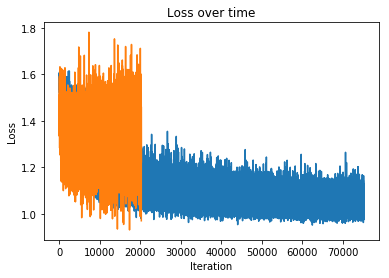

In [44]:
fig = plt.figure()
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(len(train_loss_history)), train_loss_history, label='Train Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
# fig.savefig('Loss over time (5 classes).png')

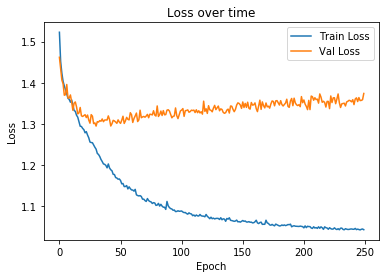

In [45]:
fig = plt.figure()
plt.title('Loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(averaged_train_loss_hist)), averaged_train_loss_hist, label='Train Loss')
plt.plot(range(len(averaged_val_loss_history)), averaged_val_loss_history, label='Val Loss')
plt.legend()
fig.savefig('final_report_imgs/Averaged Loss over time (5 classes, 250 epochs).jpg')

In [31]:
val_hist = np.asarray(val_iou_history)
train_hist = np.asarray(train_iou_history)
print(val_hist.shape)
print(train_hist.shape)

(3250, 5)
(3250, 5)


In [37]:
print(len(train_hist)/250)

13.0


In [38]:
print(len(train_hist)/250)
t_holder_0 = []
t_holder_1 = []
t_holder_2 = []
t_holder_4 = []

v_holder_0 = []
v_holder_1 = []
v_holder_2 = []
v_holder_4 = []

averaged_train_iou_0 = []
averaged_train_iou_1 = []
averaged_train_iou_2 = []
averaged_train_iou_4 = []

averaged_val_iou_0 = []
averaged_val_iou_1 = []
averaged_val_iou_2 = []
averaged_val_iou_4 = []

idx = 0
for iteration in range(len(val_hist)-1):
    t_holder_0.append(train_hist[iteration, 0])
    t_holder_1.append(train_hist[iteration, 1])
    t_holder_2.append(train_hist[iteration, 2])
    t_holder_4.append(train_hist[iteration, 4])
    
    v_holder_0.append(val_hist[iteration, 0])
    v_holder_1.append(val_hist[iteration, 1])
    v_holder_2.append(val_hist[iteration, 2])
    v_holder_4.append(val_hist[iteration, 4])
    
    if iteration % 13 == 0:
        averaged_train_iou_0.append(np.mean(np.asarray(t_holder_0)))
        averaged_train_iou_1.append(np.mean(np.asarray(t_holder_1)))
        averaged_train_iou_2.append(np.mean(np.asarray(t_holder_2)))
        averaged_train_iou_4.append(np.mean(np.asarray(t_holder_4)))

        averaged_val_iou_0.append(np.mean(np.asarray(v_holder_0)))
        averaged_val_iou_1.append(np.mean(np.asarray(v_holder_1)))
        averaged_val_iou_2.append(np.mean(np.asarray(v_holder_2)))
        averaged_val_iou_4.append(np.mean(np.asarray(v_holder_4)))
        
        t_holder_0.clear()
        t_holder_1.clear()
        t_holder_2.clear()
        t_holder_4.clear()
        v_holder_0.clear()
        v_holder_1.clear()
        v_holder_2.clear()
        v_holder_4.clear()

13.0


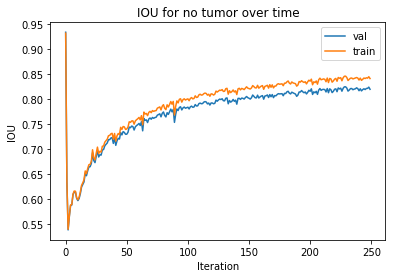

In [46]:
fig = plt.figure()
plt.title('IOU for no tumor over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(len(averaged_val_iou_0)), averaged_val_iou_0, label='val')
plt.plot(range(len(averaged_train_iou_0)), averaged_train_iou_0, label='train')
plt.legend()
fig.savefig('final_report_imgs/Averaged IOU for no tumor (5 classes, 250 epochs) - Report.png')

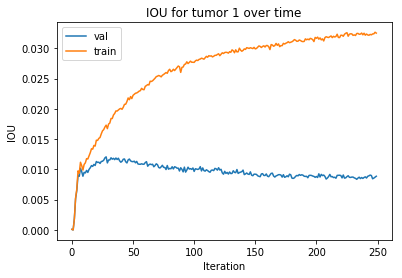

In [47]:
fig = plt.figure()
plt.title('IOU for tumor 1 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(len(averaged_val_iou_1)), averaged_val_iou_1, label='val')
plt.plot(range(len(averaged_train_iou_1)), averaged_train_iou_1, label='train')
plt.legend()
fig.savefig('final_report_imgs/Averaged IOU for tumor 1 (5 classes, 250 epochs) - Report.png')

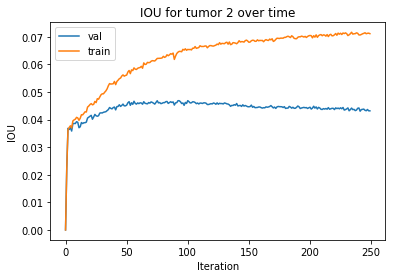

In [48]:
fig = plt.figure()
plt.title('IOU for tumor 2 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(len(averaged_val_iou_2)), averaged_val_iou_2, label='val')
plt.plot(range(len(averaged_train_iou_2)), averaged_train_iou_2, label='train')
plt.legend()
fig.savefig('final_report_imgs/Averaged IOU for tumor 2 (5 classes, 250 epochs) - Report.png')

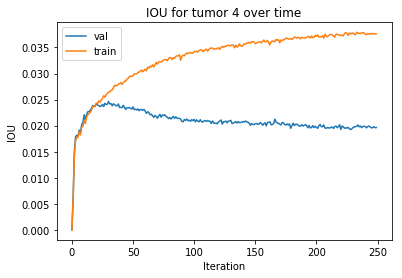

In [49]:
fig = plt.figure()
plt.title('IOU for tumor 4 over time')
plt.xlabel('Iteration')
plt.ylabel('IOU')
plt.plot(range(len(averaged_val_iou_4)), averaged_val_iou_4, label='val')
plt.plot(range(len(averaged_train_iou_4)), averaged_train_iou_4, label='train')
plt.legend()
fig.savefig('final_report_imgs/Averaged IOU for tumor 4 (5 classes, 250 epochs) - Report.png')

In [50]:
all_tumor_report_segmenation = []
all_tumor_report_segmenation.append(averaged_train_loss_hist)
all_tumor_report_segmenation.append(averaged_train_iou_0)
all_tumor_report_segmenation.append(averaged_train_iou_1)
all_tumor_report_segmenation.append(averaged_train_iou_2)
all_tumor_report_segmenation.append(averaged_train_iou_4)
all_tumor_report_segmenation.append(averaged_val_loss_history)
all_tumor_report_segmenation.append(averaged_val_iou_0)
all_tumor_report_segmenation.append(averaged_val_iou_1)
all_tumor_report_segmenation.append(averaged_val_iou_2)
all_tumor_report_segmenation.append(averaged_val_iou_4)

with open('data/pkl_files/all_tumor_arrs.pkl', 'wb') as fp:
    pickle.dump(all_tumor_report_segmenation, fp)


In [43]:
check_iou(test_loader, model)

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


array([0.84755849, 0.00843315, 0.04111269, 0.        , 0.01884245])